# CIV Analysis

This is a notebook to be used after happy with the voigt profiling and like the column densites that were calculated 

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

In [2]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')

TL;DR
- up_ch = upper limits 
- sum_df = summed values no up lims (USE FOR EVERYTHING BUT VEL PLOT) 
- com_df = comp values no up lims (USE ONLY FOR VEL PLOT)

In [3]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0
11,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0


In [4]:
#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
4,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.00000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1


In [6]:
#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = cosholes_df.loc[(cosholes_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
com_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403,0.099,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697,0.074,80.715,17.306,-9.444,12.162,1,1
5,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1548.204,0.00051,13.855,0.052,34.300,6.220,11.655,3.925,0,1
6,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,62.794963,...,1548.204,0.00081,13.652,0.103,10.925,4.852,-2.260,2.533,0,1
7,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,29.956925,...,1548.204,0.00109,13.946,0.044,30.000,4.293,-11.070,2.849,0,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990,0.057,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012,0.076,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211,0.053,54.100,7.973,18.210,5.687,1,1


In [241]:
#M31 Data (Project AMIGA) Detections (and taking out the MS contaminations) 

amiga_2_det_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_det_sum.csv')
amiga_2_det_sum = amiga_2_det_sum.loc[(amiga_2_det_sum['sumlogN']!= 0)]
amiga_2_det_sum = amiga_2_det_sum.loc[amiga_2_det_sum['MS']==0]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
#making sure to use r200 as a substitute for since that is what we used 
amiga_m31_rvrir = 230 #kpc This is the value used for R200 in the paper? 

amiga_det_R = np.array(amiga_2_det_sum['Rad'])
amiga_det_RRvir = amiga_det_R/amiga_m31_rvrir

#amiga_2_det_sum

In [242]:
#M31 Data (Project AMIGA) non-detections (upper limits) and taking out the MS contamination
amiga_2_up_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_up_sum.csv')
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['sumlogN']!= 0)]
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['MS']== 0)]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
amiga_up_R = np.array(amiga_2_up_sum['Rad'])
amiga_up_RRvir = amiga_up_R/amiga_m31_rvrir

#amiga_2_up_sum

## Galaxy Parameter Plots

In [205]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

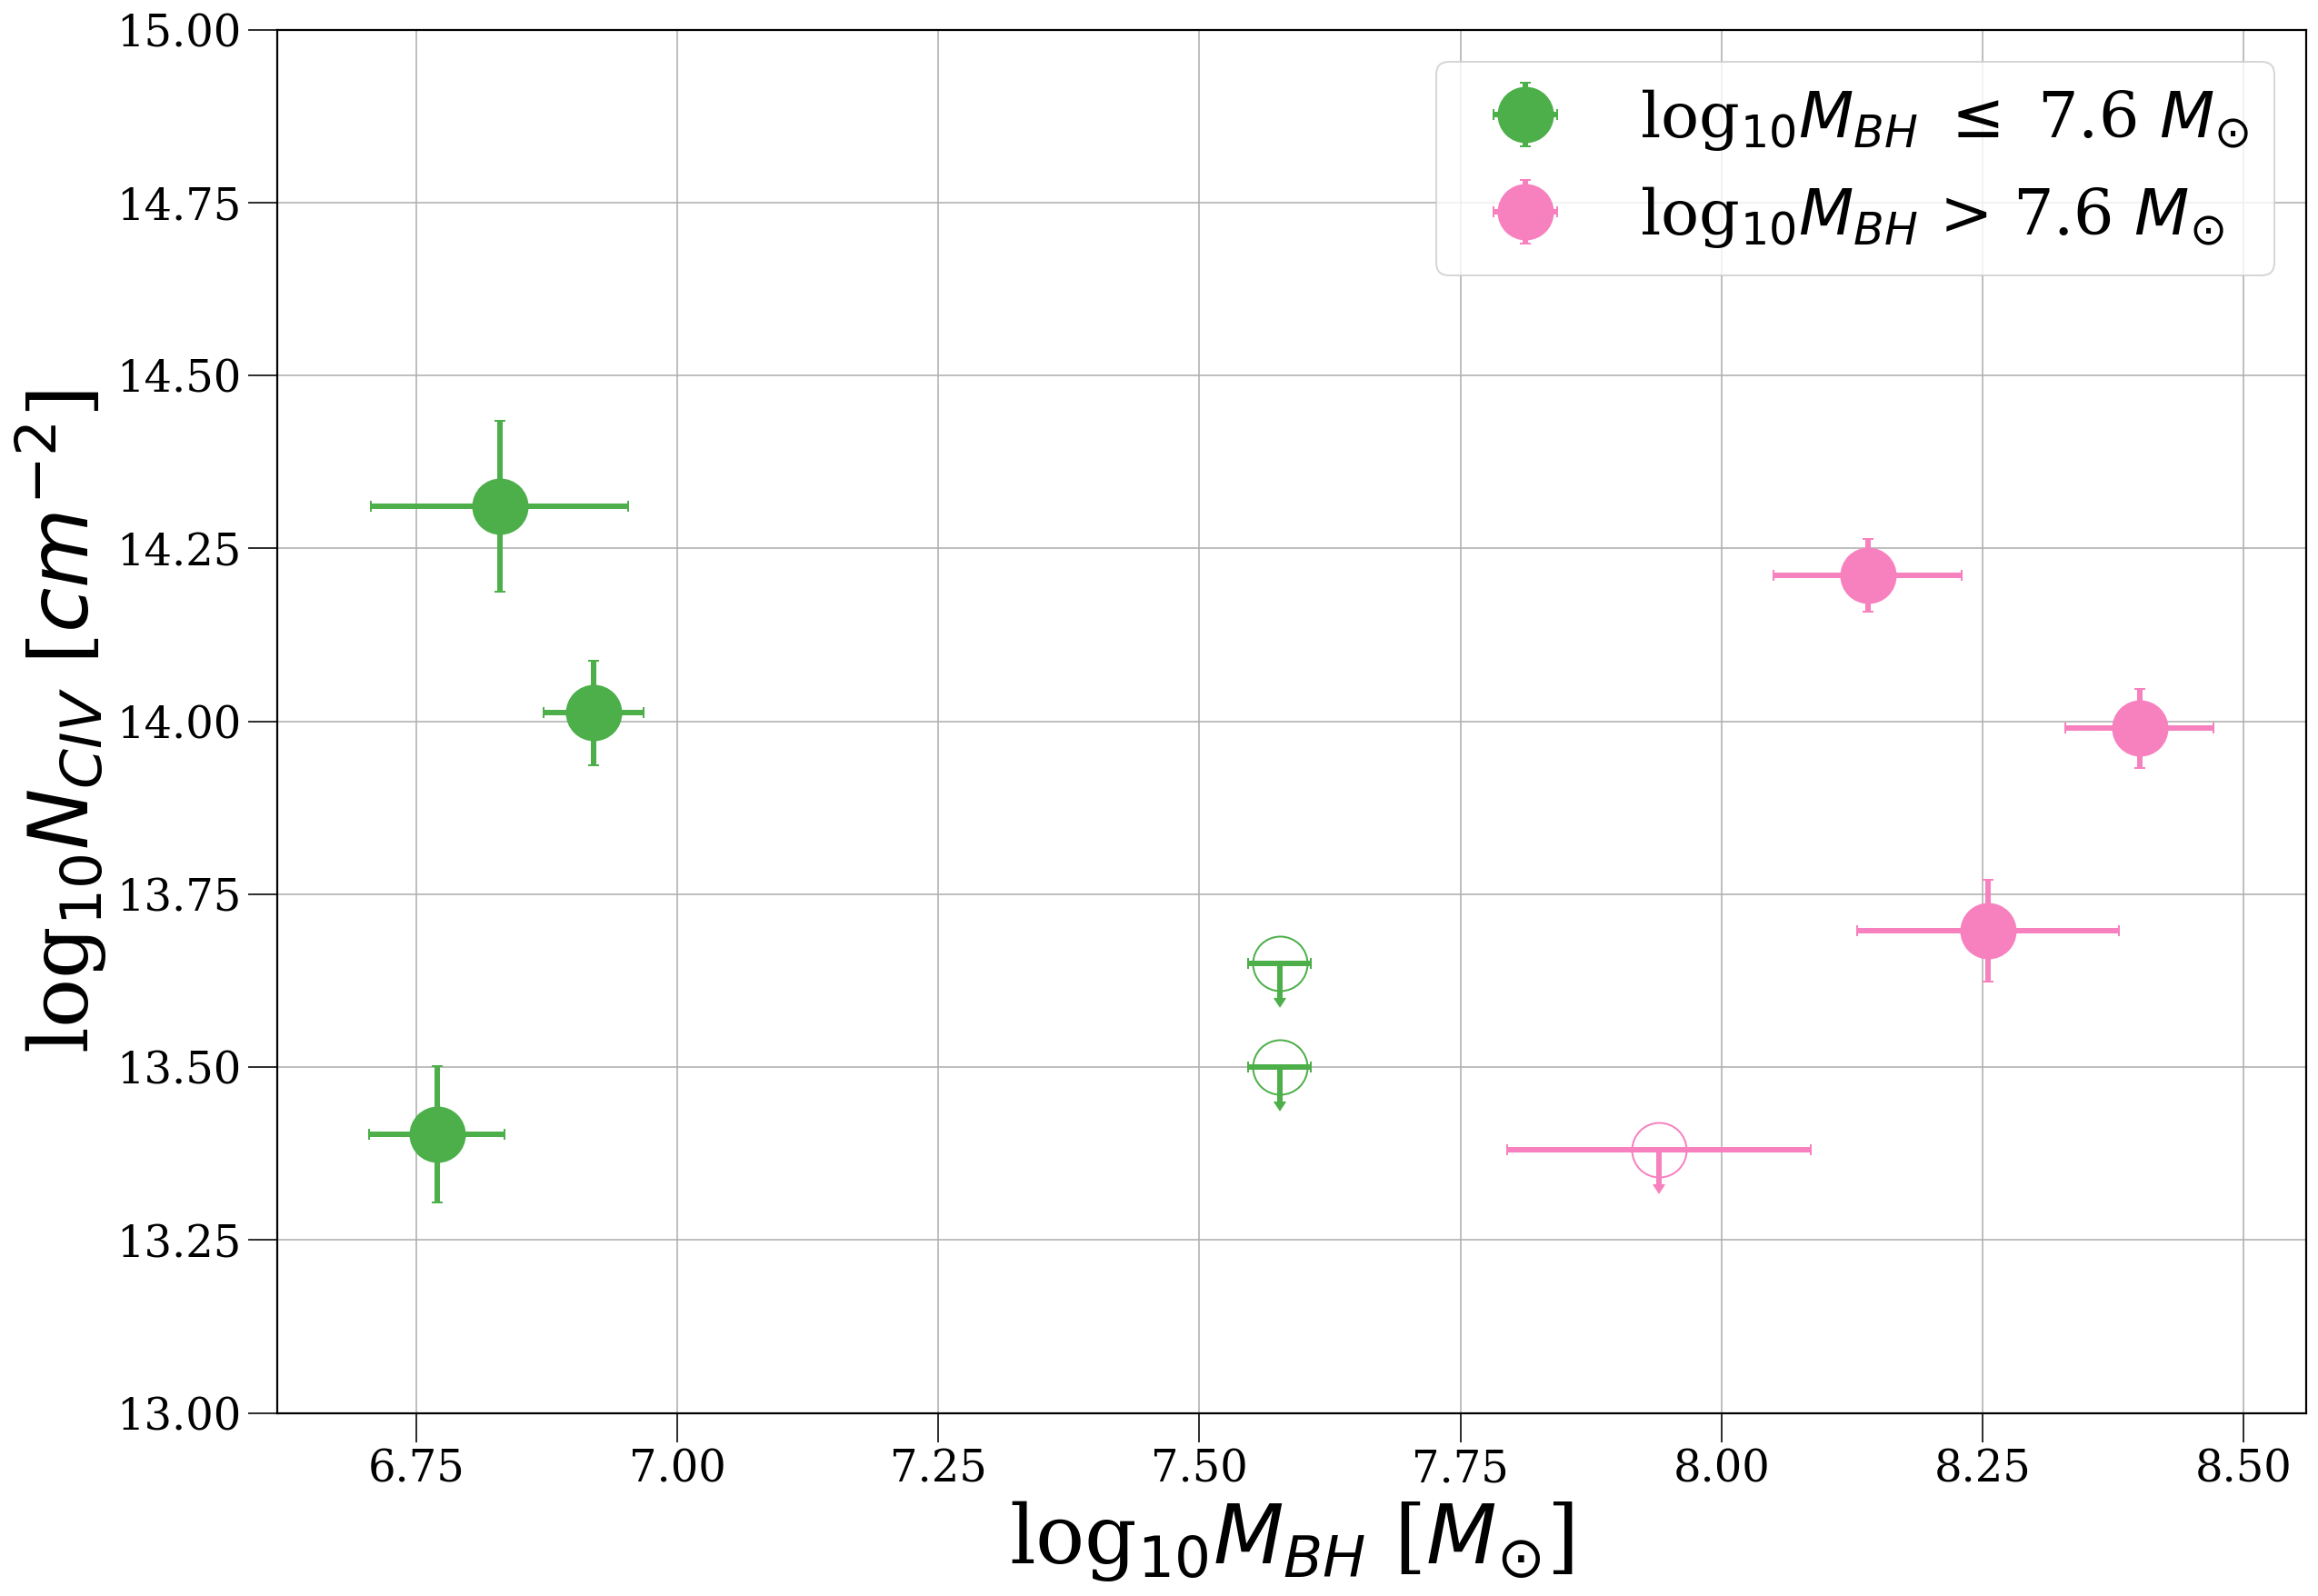

In [234]:
#creating masks to separate into high and low 
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)
    

#Plotting NCIV vs MBH    
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["MBH"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["MBH"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(fontsize=35)
ax.set_xlabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(13, 15)
plt.grid(True)
#plt.savefig('Figures/nciv_vs_bh.png')
plt.show()

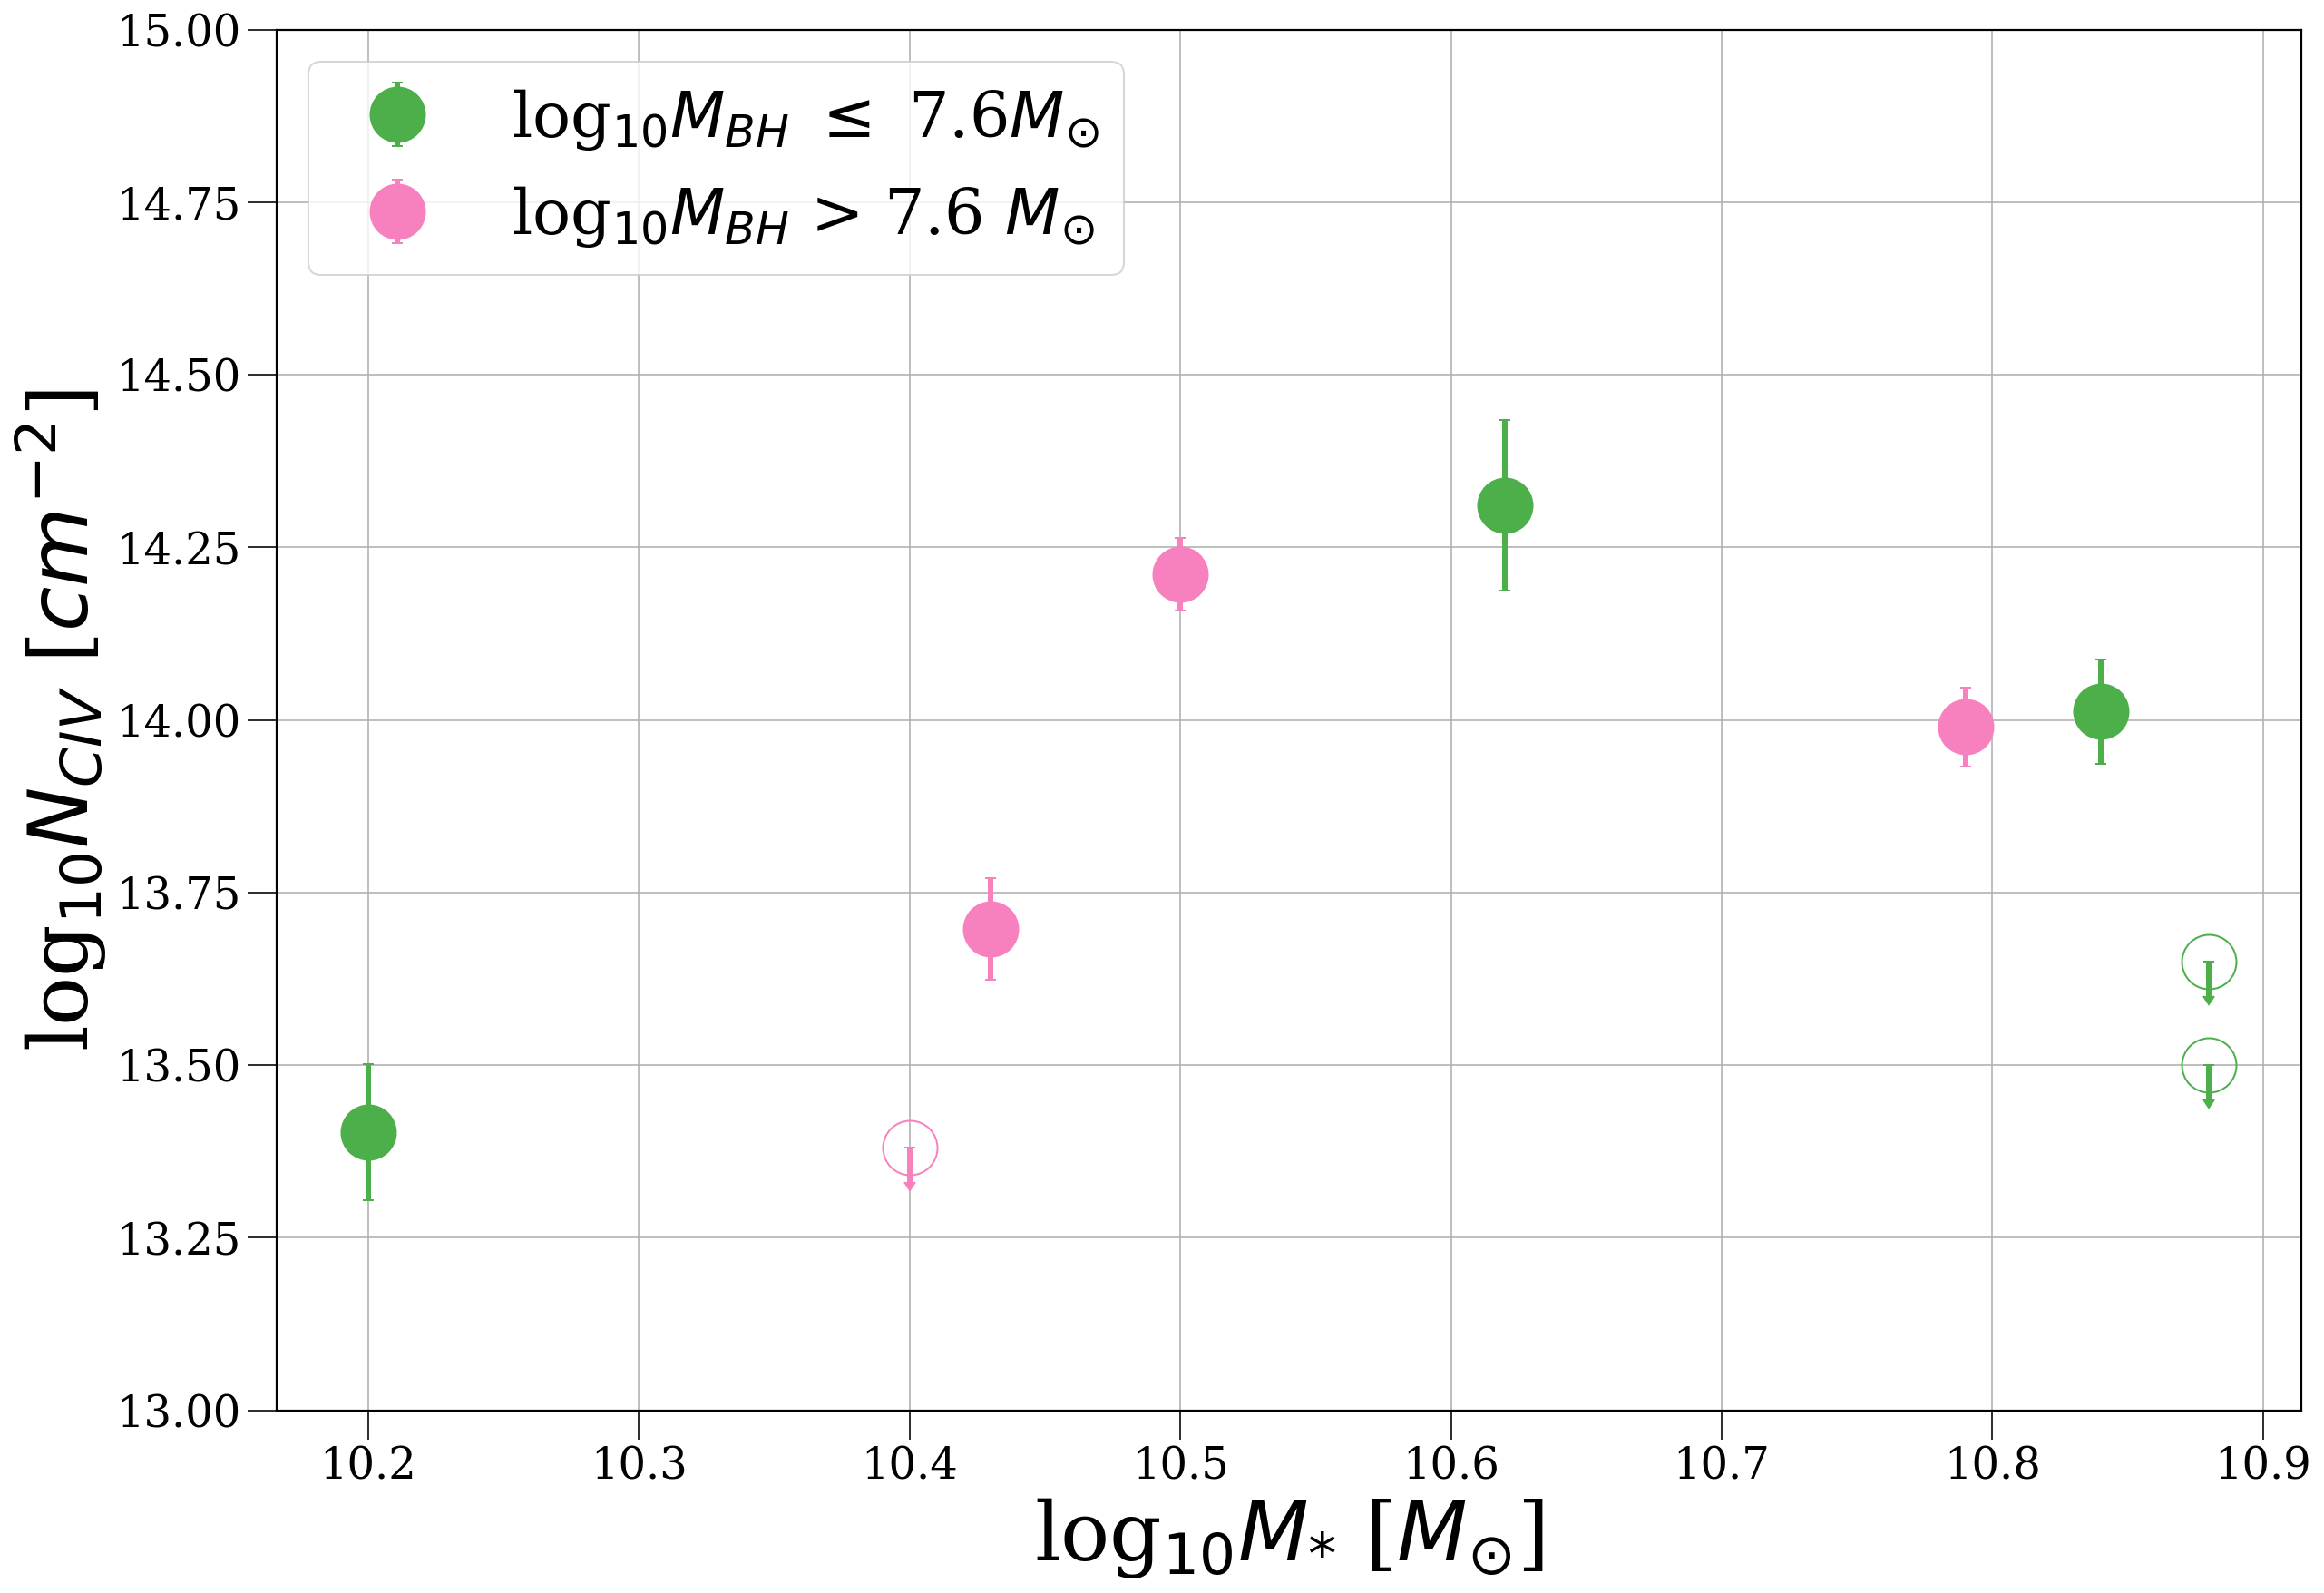

In [223]:
#Plotting NCIV vs M*    
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6$M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["M*"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["M*"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=2, fontsize=35)
ax.set_xlabel(r"log$_{10}M_{*}$ [$M_{\odot}$]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(13, 15)
plt.grid(True)
plt.show()

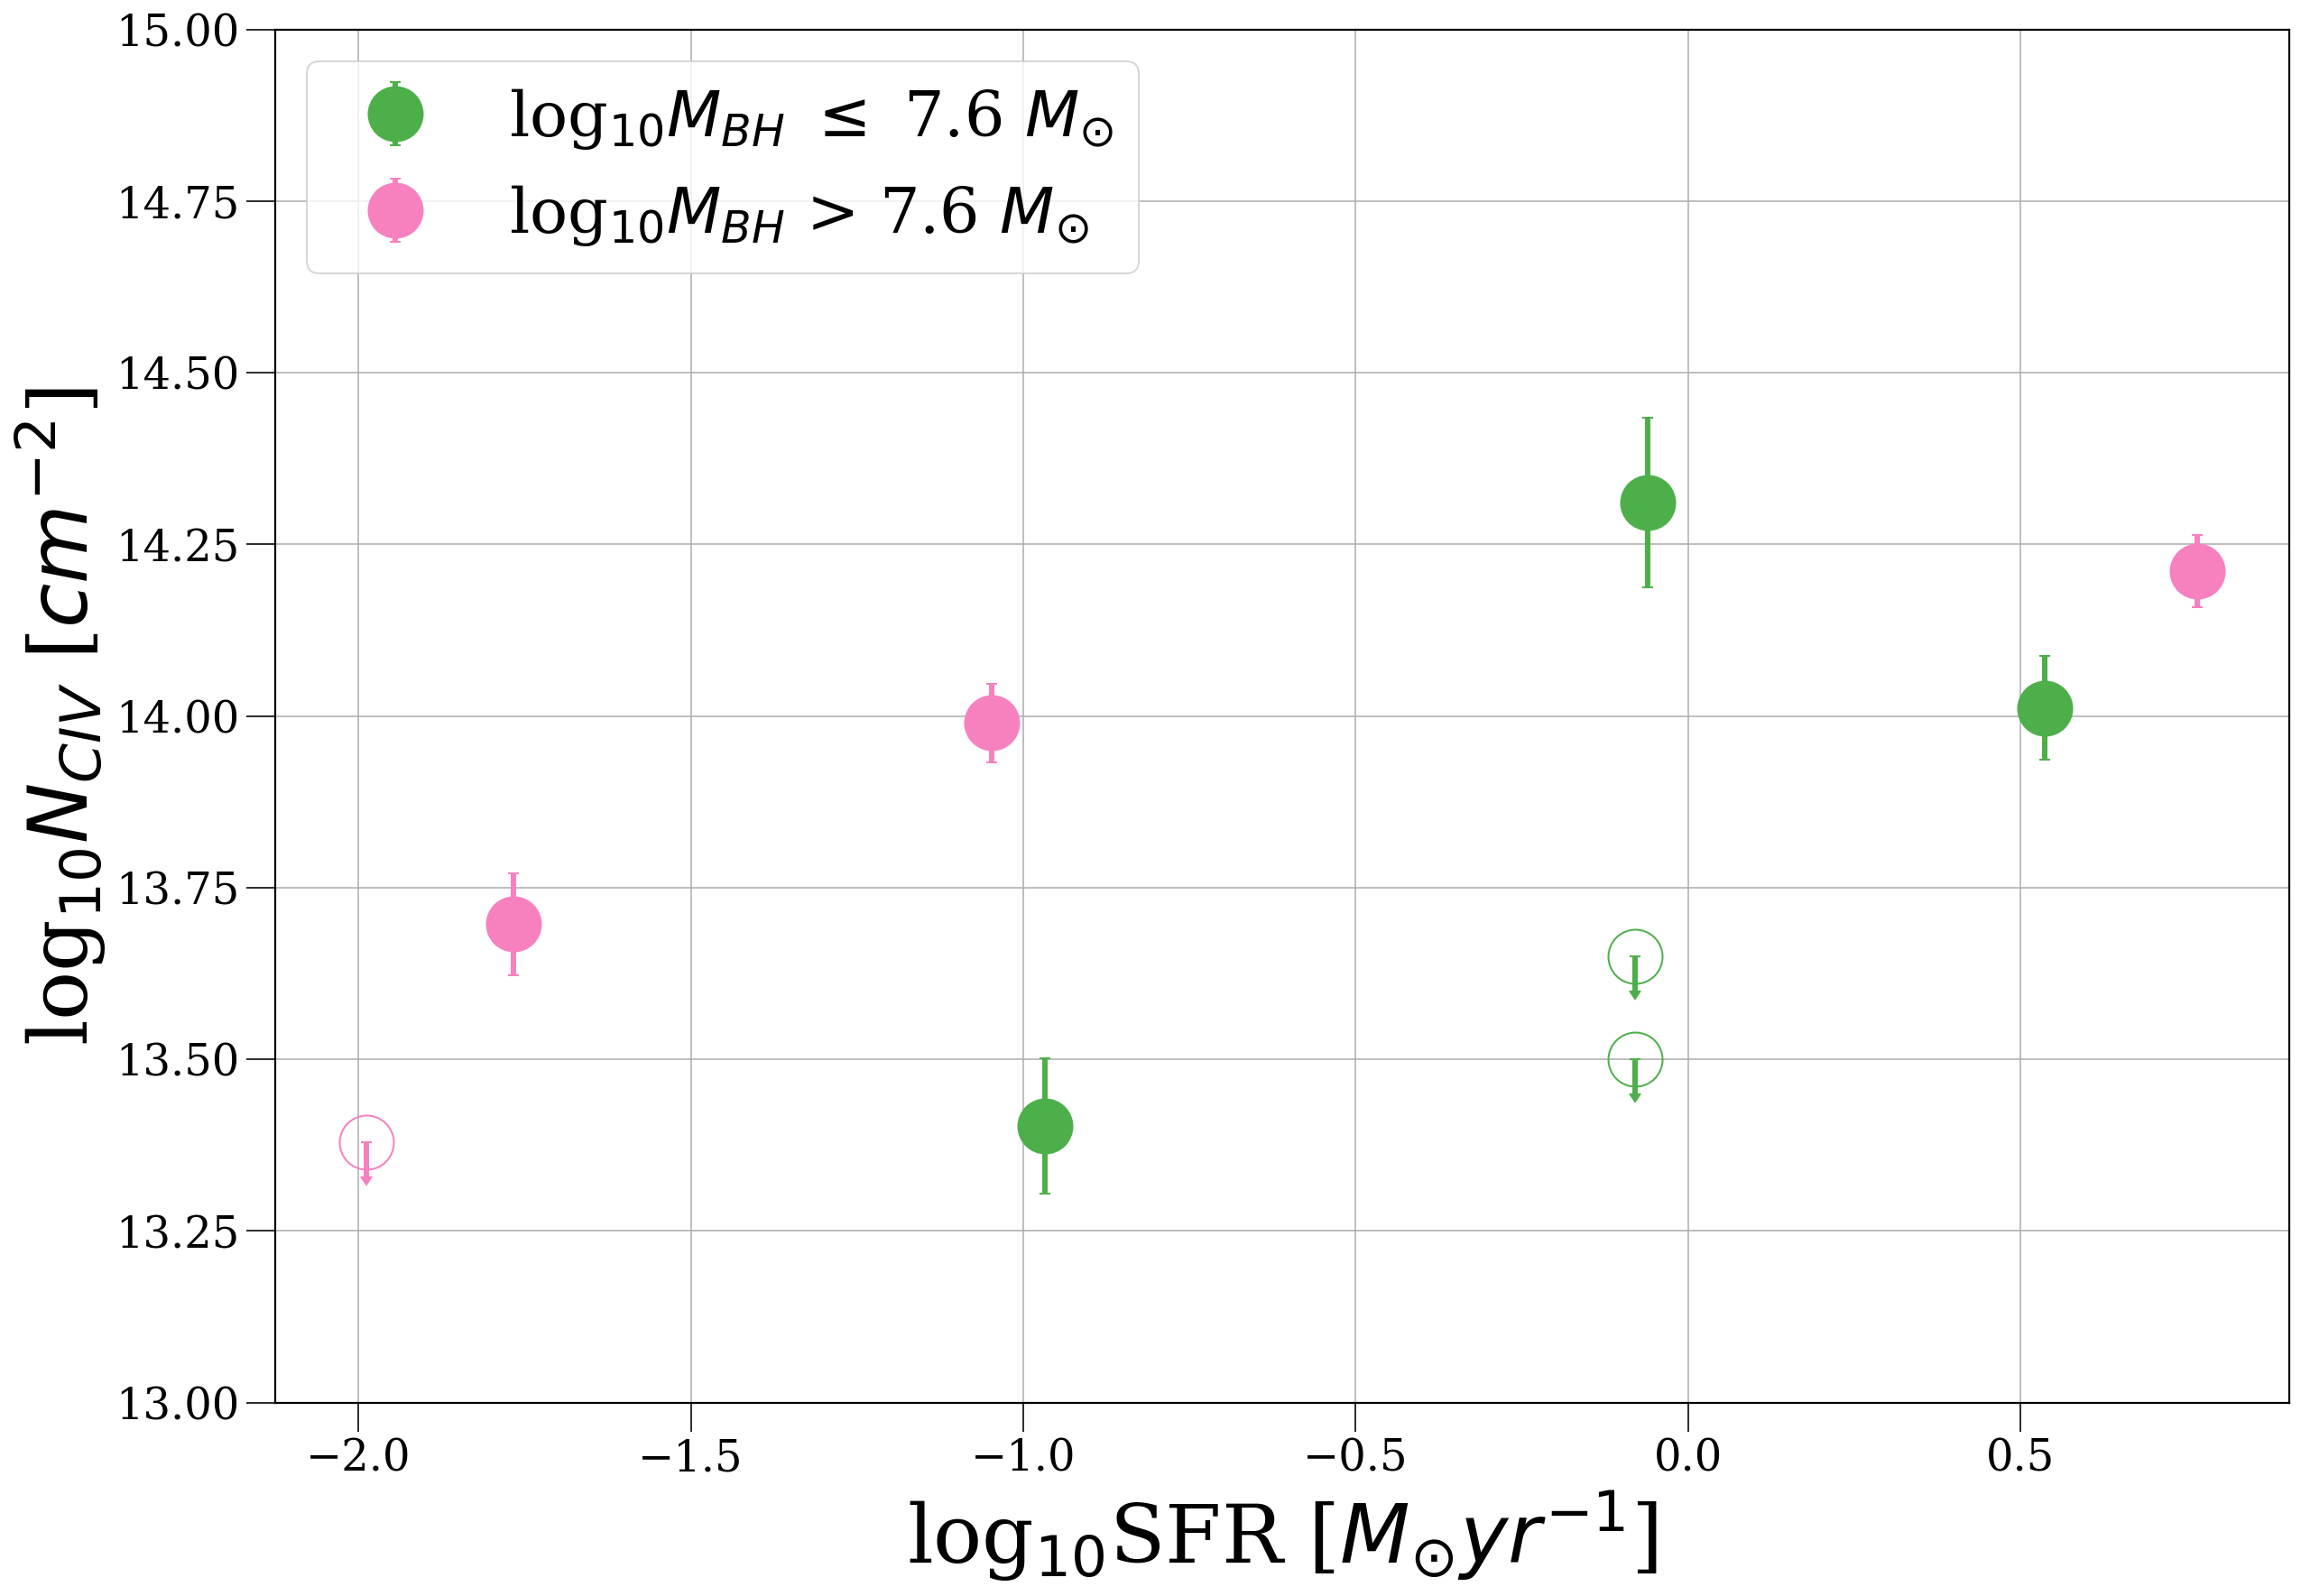

In [224]:
#Plotting NCIV vs SFR    
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["SFR"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["SFR"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=2, fontsize=35)
ax.set_xlabel(r"log$_{10}$SFR [$M_{\odot} yr^{-1}$]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
plt.grid(True)
ax.set_ylim(13, 15)
plt.show()

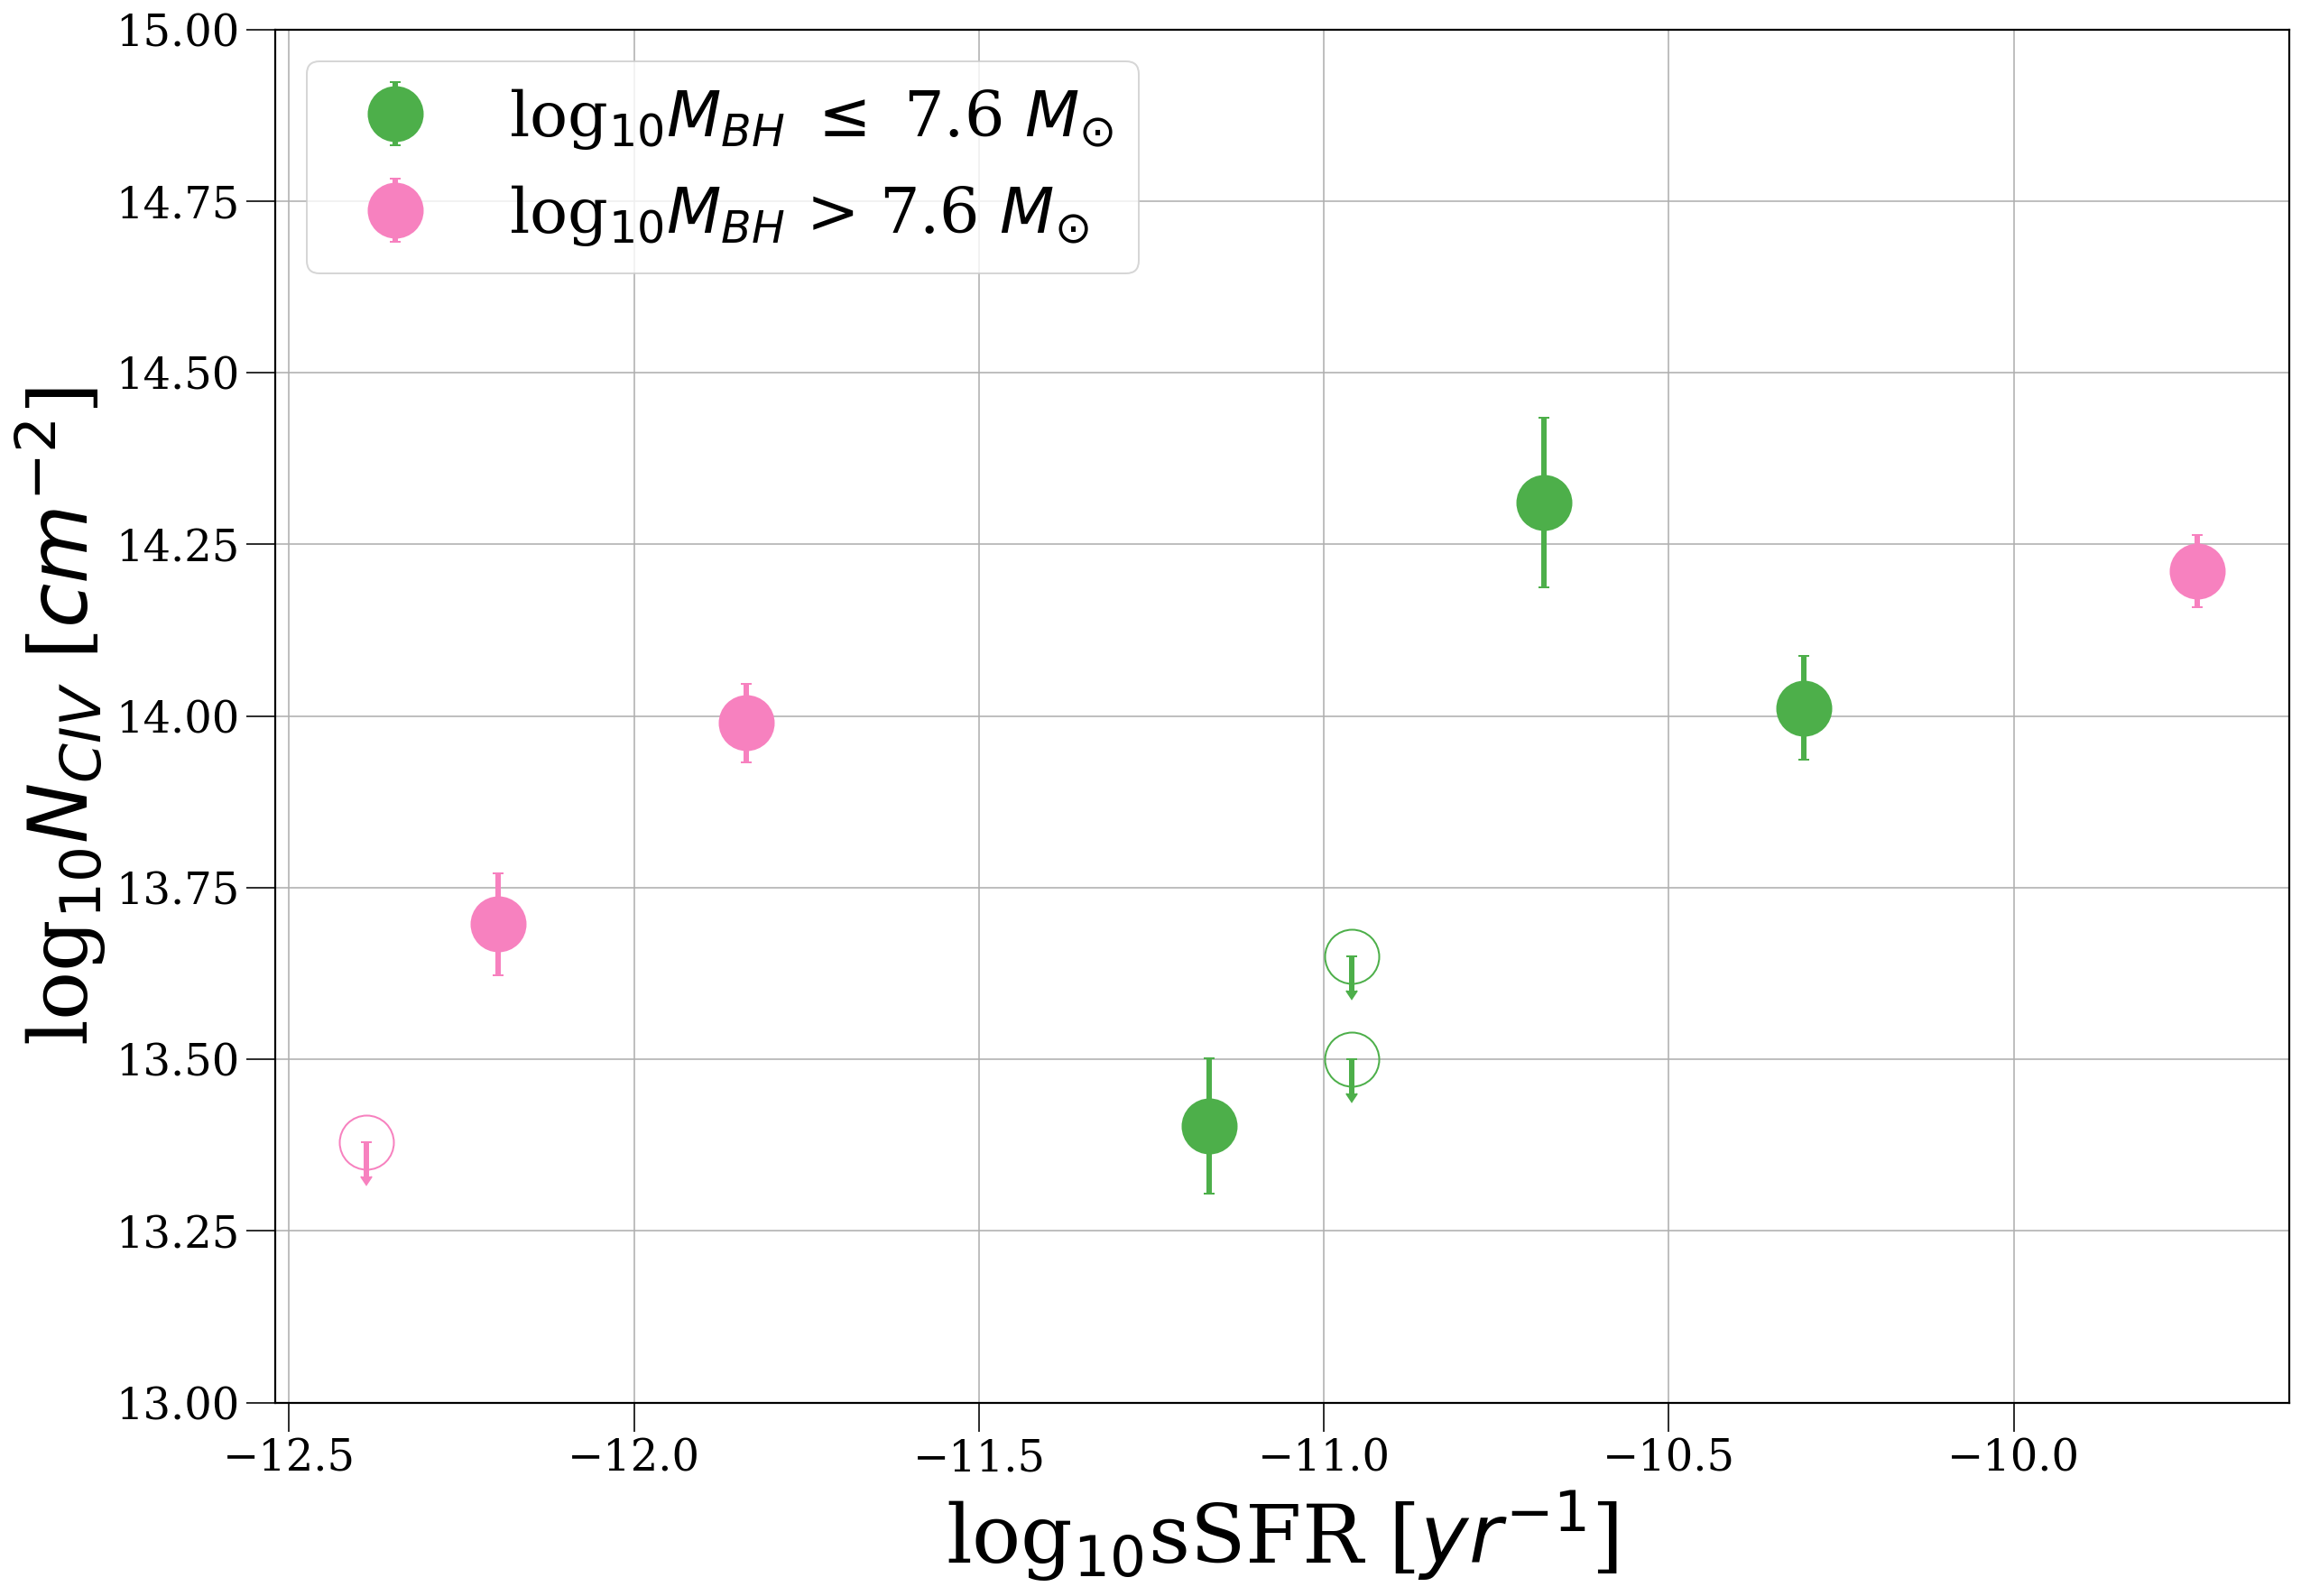

In [235]:
#Plotting NCIV vs sSFR    
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["SFR"][mask] - sum_ch["M*"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["SFR"][mask] -up_ch['M*'][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=2, fontsize=35)
ax.set_xlabel(r"log$_{10}$sSFR [$yr^{-1}$]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
plt.grid(True)
ax.set_ylim(13, 15)
#plt.savefig('Figures/nciv_vs_ssfr.png')
plt.show()

## Galaxy Kinematics Plot

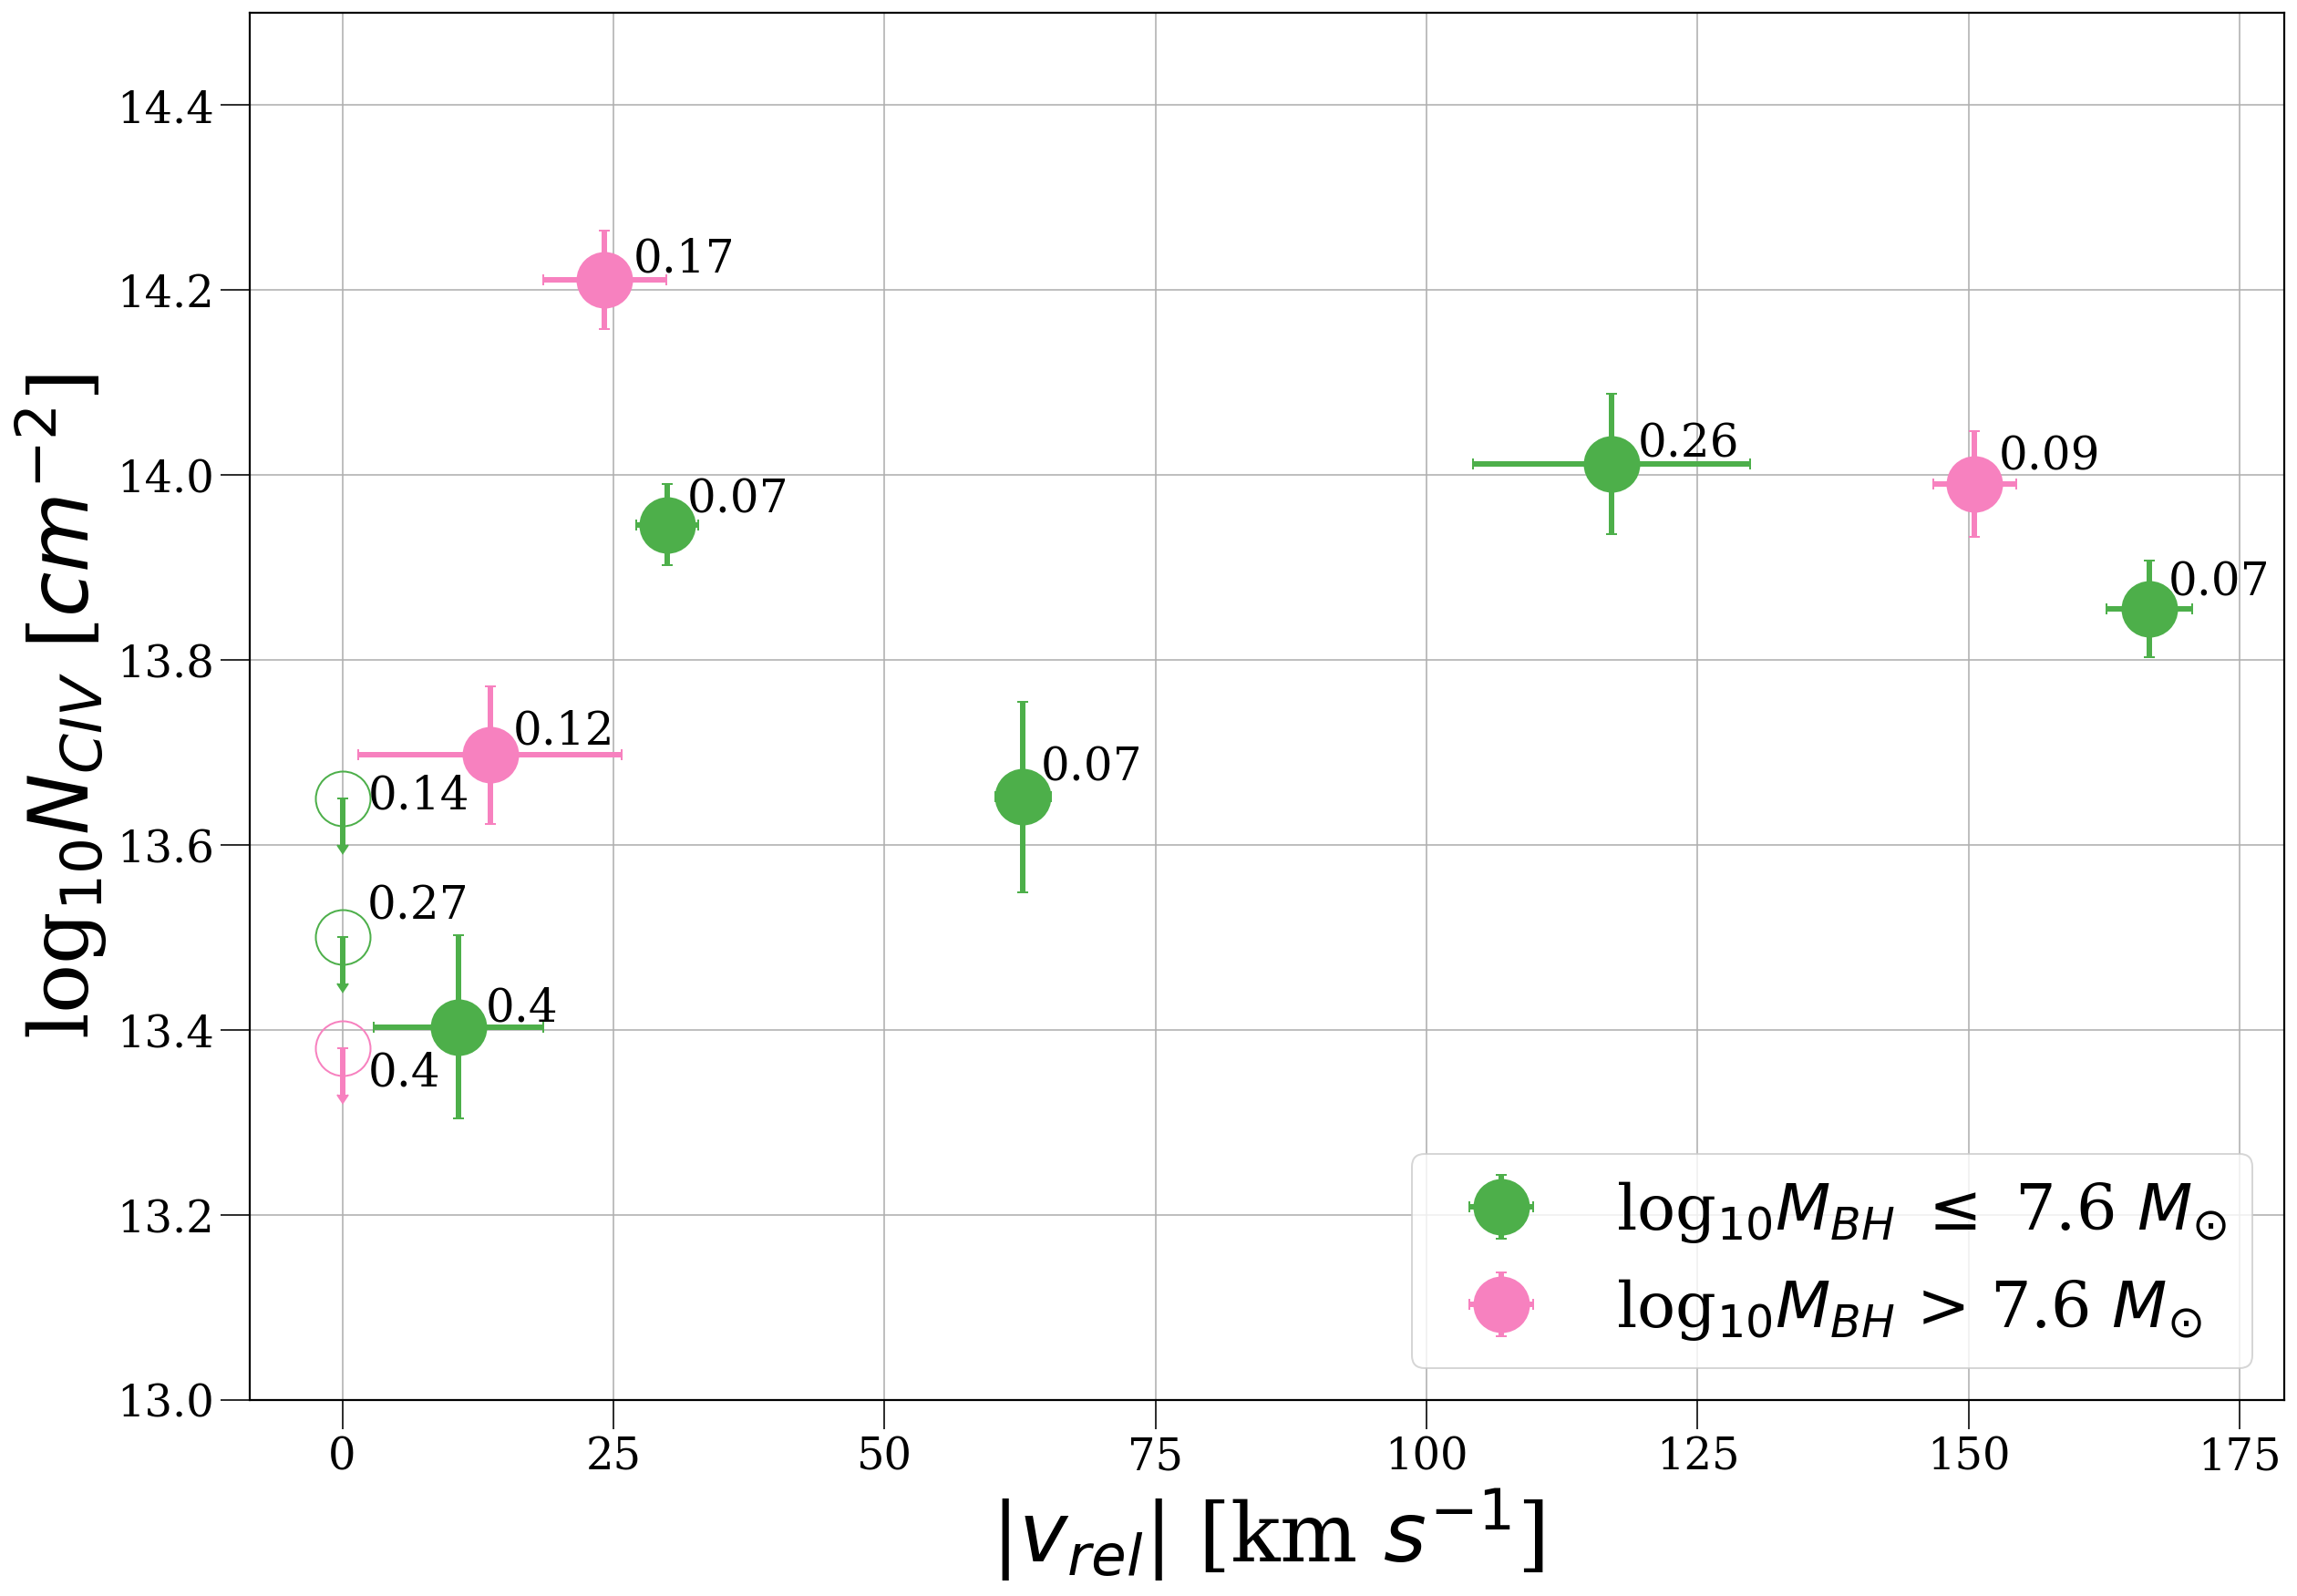

In [236]:
#Plotting NCIV vs |vrel|   
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(com_ch["vrel"][mask], com_ch['N'][mask],yerr=com_ch['sigN'][mask],xerr=np.abs(com_ch['sigvel'][mask]), 
                capsize = 3, c = colour, marker=".", markersize=60, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["vrel"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=60, ls='none', uplims=True, mfc='none', elinewidth=3)

plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][0],2)}", (13.2, 13.41), fontsize=25) #J1101
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][1],2)}", (15.7, 13.71), fontsize=25) #J1159
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][5],2)}", (168.4, 13.87), fontsize=25) #J1249
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][6],2)}", (64.4, 13.67), fontsize=25) #J1249
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][7],2)}", (31.8, 13.96), fontsize=25) #J1249
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][8],2)}", (152.8, 14.006), fontsize=25) #J1051
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][9],2)}", (119.5, 14.02), fontsize=25) #J1123
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][10],2)}", (26.8, 14.22), fontsize=25) #J0246

plt.annotate(f"{np.round(up_ch['Rproj/Rvir'][2],2)}", (2.34, 13.64), fontsize=25) #J1220
plt.annotate(f"{np.round(up_ch['Rproj/Rvir'][3],2)}", (2.33, 13.52), fontsize=25) #J1222
plt.annotate(f"{np.round(up_ch['Rproj/Rvir'][11],2)}", (2.34, 13.34), fontsize=25) #J1235

ax.legend(loc=4, fontsize=35)
ax.set_xlabel(r"|$v_{rel}$| [km $s^{-1}$]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(13, 14.5)
plt.grid(True)
#plt.savefig('Figures/nciv_vs_rel_vel.png')
plt.show()

## Comparing COS-Holes to Simulations 

### EAGLE

In [243]:
df_rr_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.6.6_7.6.dat",sep="\s+")
df_rr_new_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.7.6_8.6.dat",sep="\s+")

df_r_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.6.6_7.6.dat",sep="\s+")
df_r_new_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.7.6_8.6.dat",sep="\s+")

<>:1: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/2210995085.py:1: DeprecationWarning: invalid escape sequence \s
  df_rr_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.6.6_7.6.dat",sep="\s+")
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_378

<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/2359221149.py:10: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_new_high['#R(kpc)'], df_r_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}$ > 7.6 $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/2359221149.py:12: DeprecationWarning: invalid escape sequence \l
  plt.plot(df_r_new_low['#R(kpc)'], df_r_new_low['median'], color = CB_color_cycle[2], lw = 5, label = 'EAGLE: 

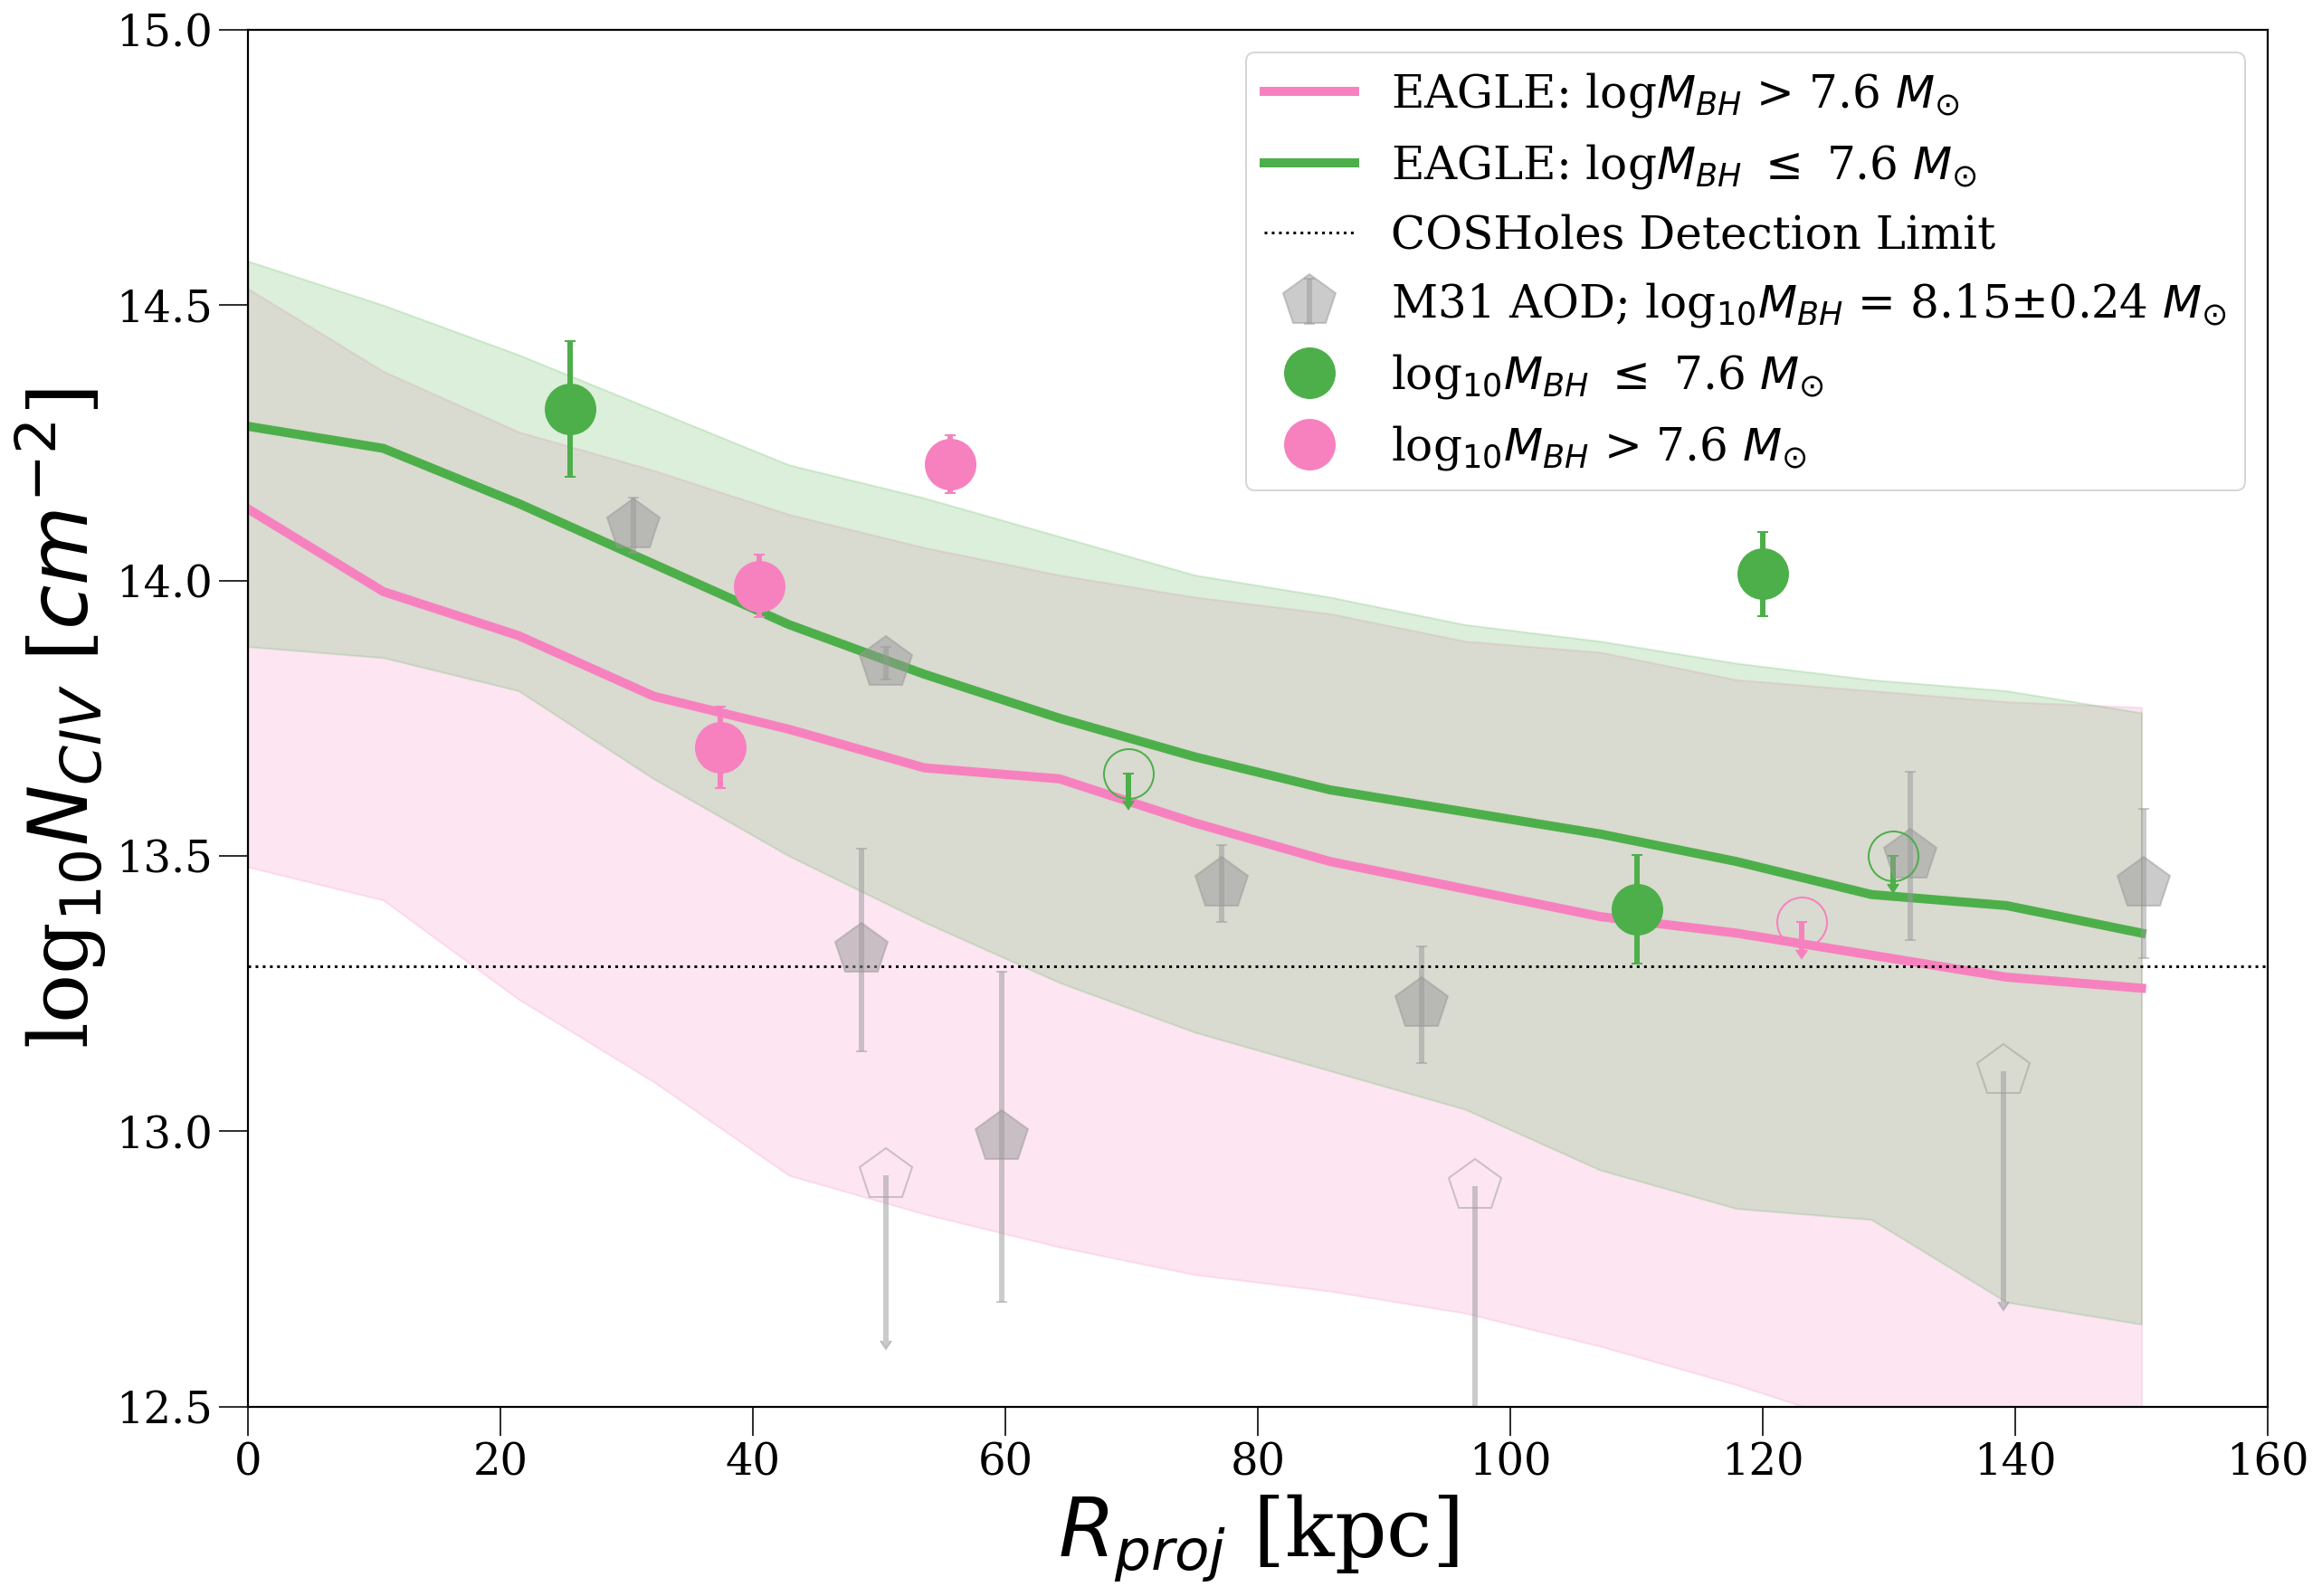

In [244]:
#Plotting NCIV vs Rproj 
    
fig, ax = plt.subplots()

########################################################

#EAGLE Simulational Data

plt.fill_between(df_r_new_high['#R(kpc)'], df_r_new_high['16percentile'], df_r_new_high['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
plt.plot(df_r_new_high['#R(kpc)'], df_r_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}$ > 7.6 $M_{\odot}$')
plt.fill_between(df_r_new_low['#R(kpc)'], df_r_new_low['16percentile'], df_r_low['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
plt.plot(df_r_new_low['#R(kpc)'], df_r_new_low['median'], color = CB_color_cycle[2], lw = 5, label = 'EAGLE: log$M_{BH}$ $\leq$ 7.6 $M_{\odot}$')

   
########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 , used lightgrey before 

##### M31 Detections (Sums) 
plt.errorbar (amiga_2_det_sum['Rad'], amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha = 0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_2_up_sum['Rad'], amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.5, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=1, fontsize=25)
ax.set_xlabel(r"$R_{proj}$ [kpc]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12.5, 15)
ax.set_xlim(0, 160)
#plt.savefig('Figures/nciv_eagle_vs_r.png')
plt.show()

<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:21: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:21: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:21: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/2258559992.py:10: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_rr_new_high['#R/R200'], df_rr_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}$ > 7.6 $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/2258559992.py:12: DeprecationWarning: invalid escape sequence \l
  plt.plot(df_rr_new_low['#R/R200'], df_rr_new_low['median'], color = CB_color_cycle[2], lw = 5, label = 'EAG

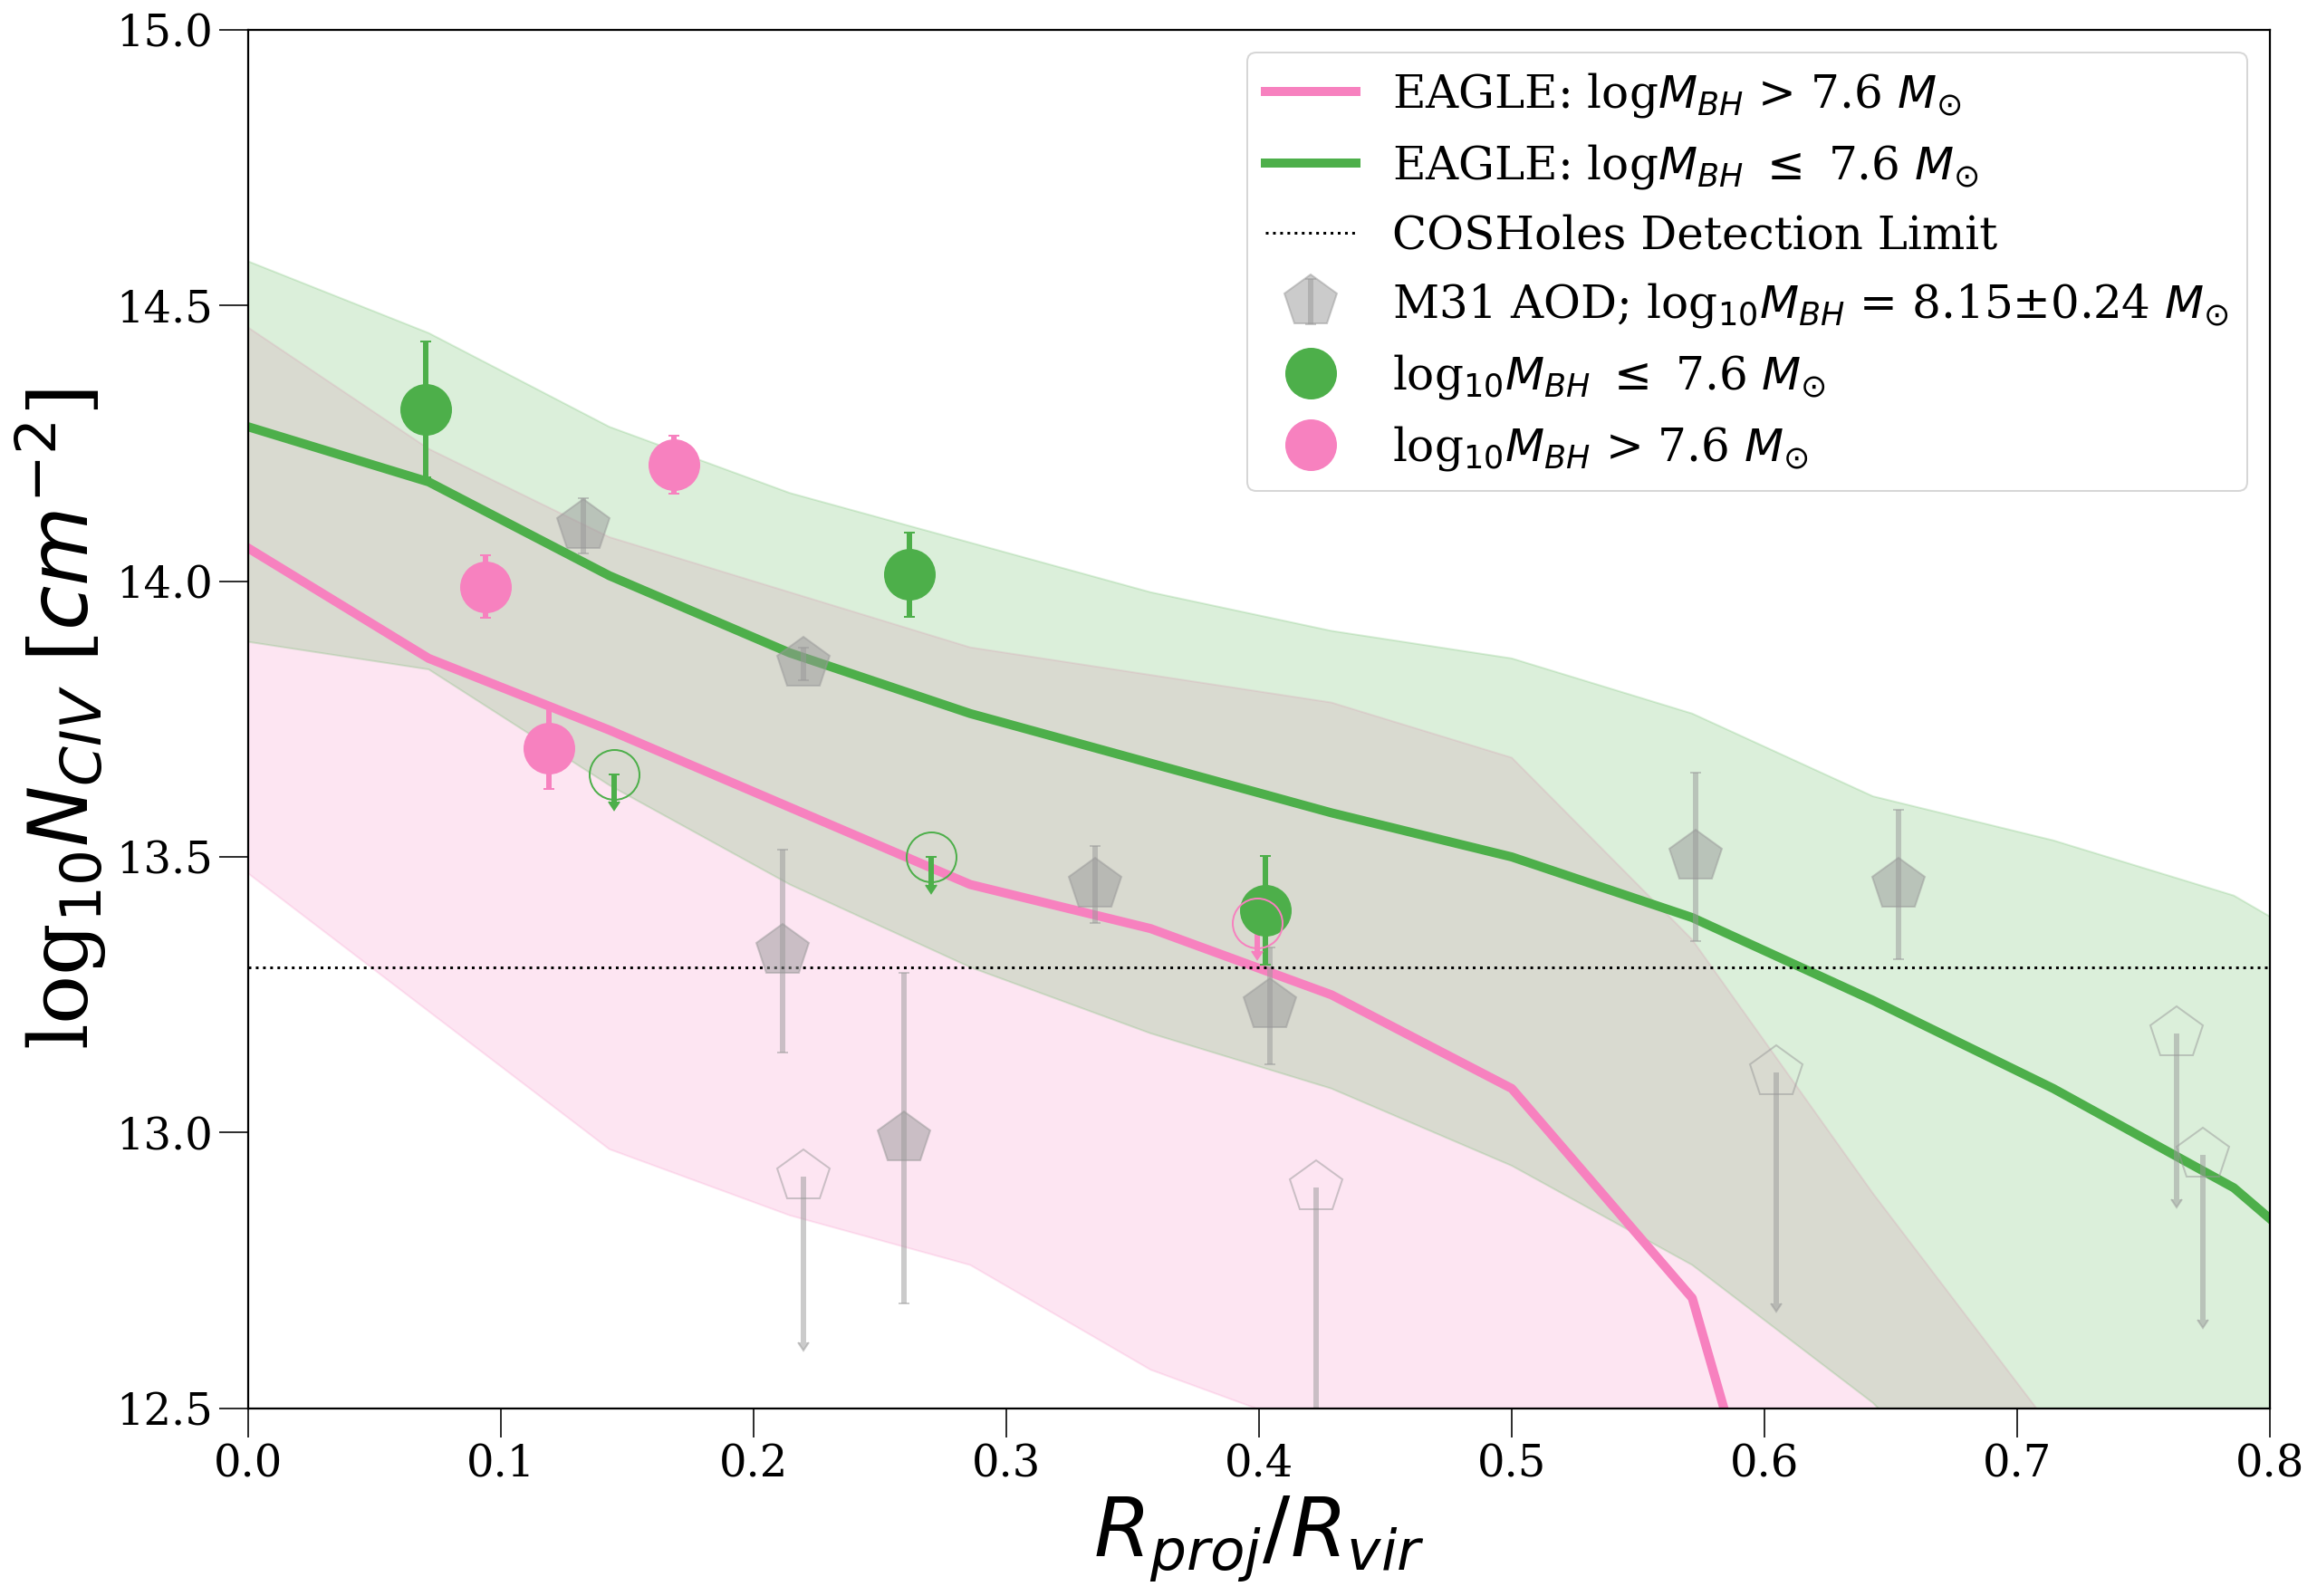

In [371]:
#Plotting NCIV vs Rproj/Rvir

fig, ax = plt.subplots()

########################################################

#EAGLE

plt.fill_between(df_rr_new_high['#R/R200'], df_rr_new_high['16percentile'], df_rr_new_high['84percentile'], alpha = 0.2, color = CB_color_cycle[3])
plt.plot(df_rr_new_high['#R/R200'], df_rr_new_high['median'], color = CB_color_cycle[3], lw = 5, label = 'EAGLE: log$M_{BH}$ > 7.6 $M_{\odot}$')
plt.fill_between(df_rr_new_low['#R/R200'], df_rr_new_low['16percentile'], df_rr_new_low['84percentile'], alpha = 0.2, color = CB_color_cycle[2])
plt.plot(df_rr_new_low['#R/R200'], df_rr_new_low['median'], color = CB_color_cycle[2], lw = 5, label = 'EAGLE: log$M_{BH}$ $\leq$ 7.6 $M_{\odot}$')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha =0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.5, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=1, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12.5, 15)
ax.set_xlim(0, 0.8)
#plt.savefig('Figures/nciv_eagle_vs_rr.png')
plt.show()

#### Calculating Simga Values for EAGLE

In [251]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the sum values 
eagle_sum = {'QSO': ['J1101', 'J1159', 'J1249', 'J1051', 'J1123', 'J0246'],
             'R': [df_r_new_low['#R(kpc)'][10], df_r_new_high['#R(kpc)'][3], df_r_new_low['#R(kpc)'][2], df_r_new_high['#R(kpc)'][4],
               df_r_new_low['#R(kpc)'][11], df_r_new_high['#R(kpc)'][5]],
         'RR': [df_rr_new_low['#R/R200'][6], df_rr_new_high['#R/R200'][2], df_rr_new_low['#R/R200'][1], df_rr_new_high['#R/R200'][1],
                df_rr_new_low['#R/R200'][4], df_rr_new_high['#R/R200'][2]],
        'medianCIV': [df_r_new_low['median'][10], df_r_new_high['median'][3], df_r_new_low['median'][2], df_r_new_high['median'][4], 
                     df_r_new_high['median'][11], df_r_new_high['median'][5]], 
            'medianCIVRR': [df_rr_new_low['median'][6], df_rr_new_low['median'][2], df_rr_new_low['median'][1], df_rr_new_low['median'][1], 
                           df_rr_new_low['median'][4], df_rr_new_low['median'][2]]}
E_sum = pd.DataFrame(data=eagle_sum)

In [252]:
#New larger df with Eagle values included 
E_sum_ch = pd.merge(sum_ch, E_sum, on="QSO")
E_sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,Rproj,Rvir,Rproj/Rvir,line,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim,R,RR,medianCIV,medianCIVRR
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,110.019140,273.43553,0.402359,CIV,1548.204,0.00223,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1,107.10,0.42860,13.54,13.58
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,37.385240,314.35077,0.118928,CIV,1548.204,0.00330,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1,32.14,0.14290,13.79,14.01
2,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,25.520224,363.76792,0.070155,CIV,1548.204,0.00000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1,21.43,0.07143,14.14,14.18
3,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,40.499140,431.64653,0.093825,CIV,1548.204,0.00442,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1,42.86,0.07143,13.73,14.18
4,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,119.976000,458.29968,0.261785,CIV,1548.204,0.00275,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1,117.90,0.28570,13.36,13.76
5,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,55.657239,330.32571,0.168492,CIV,1548.204,0.00422,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1,53.57,0.14290,13.66,14.01


In [253]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the uplim values 

eagle_uplim = {'QSO': ['J1220', 'J1222', 'J1235'],
               'R': [df_r_low['#R(kpc)'][6], df_r_low['#R(kpc)'][12], df_r_high['#R(kpc)'][12]],
         'RR': [df_rr_low['#R/R200'][2], df_rr_low['#R/R200'][4], df_rr_high['#R/R200'][6]],
        'medianCIV': [df_r_low['median'][6], df_r_low['median'][12], df_r_high['median'][12]], 
            'medianCIVRR': [df_rr_low['median'][2], df_rr_low['median'][4], df_rr_high['median'][6]]}
E_up = pd.DataFrame(data=eagle_uplim)

In [254]:
#New larger df with Eagle values included 
E_up_ch = pd.merge(up_ch, E_up, on="QSO")
E_up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,Rproj,Rvir,Rproj/Rvir,line,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim,R,RR,medianCIV,medianCIVRR
0,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,69.778997,482.42196,0.144643,CIV,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0,64.29,0.1429,13.73,14.01
1,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,130.305660,482.42196,0.270107,CIV,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0,128.60,0.2857,13.41,13.75
2,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,123.078500,308.12739,0.399440,CIV,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0,128.60,0.4286,13.32,13.25


In [255]:
#The actual stats part 

import statistics
import math

#Need these things in arrays to make it easier to run through the function 
E_sum_medCIV = np.array(E_sum_ch['medianCIV'])
E_sum_medCIVRR = np.array(E_sum_ch['medianCIVRR'])
sum_civ = np.array(E_sum_ch['N'])

#Checking this using the low values because they are closer to the simulation predictions 
def variance(med, data): 
    # Number of observations
    n = len(data)
    
    #mean of the data => using the median values from EAGLE 
    mean = med 
    
    #square deviations
    devs = (data-mean)**2 
    
    #variance
    variance = devs
    return variance    

##### SUMMED VALUES (DET)

In [256]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (E_sum_ch["MBH"] <= 7.6), (E_sum_ch["MBH"] > 7.6)


#For the Rproj plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_sum_medCIV, sum_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj Calculations in {label}: {(std*100)[mask]}')

Sigma values for Rproj Calculations in Low MBH Sample: [13.7      17.132331 65.2     ]
Sigma values for Rproj Calculations in High MBH Sample: [ 9.3 26.  55.1]


In [257]:
#For the Rproj/Rvir plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_sum_medCIVRR, sum_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj/Rvir Calculations in {label}: {(std*100)[mask]}')

Sigma values for Rproj/Rvir Calculations in Low MBH Sample: [17.7      13.132331 25.2     ]
Sigma values for Rproj/Rvir Calculations in High MBH Sample: [31.3 19.  20.1]


#### UPPER LIMITS (NON-DET)

In [258]:
#Need these things in arrays to make it easier to run through the function 
E_up_medCIV = np.array(E_up_ch['medianCIV'])
E_up_medCIVRR = np.array(E_up_ch['medianCIVRR'])
up_civ = np.array(E_up_ch['N'])

In [259]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (E_up_ch["MBH"] <= 7.6), (E_up_ch["MBH"] > 7.6)


#For the Rproj plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_up_medCIV, up_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj Calculations in {label}: {(std*100)[mask]}')

Sigma values for Rproj Calculations in Low MBH Sample: [8. 9.]
Sigma values for Rproj Calculations in High MBH Sample: [6.]


In [260]:
#For the Rproj/Rvir plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_up_medCIVRR, up_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj/Rvir Calculations in {label}: {(std*100)[mask]}')

Sigma values for Rproj/Rvir Calculations in Low MBH Sample: [36. 25.]
Sigma values for Rproj/Rvir Calculations in High MBH Sample: [13.]


### R25

In [30]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [325]:
#Nicole Data (R25 - Rproj/Rvir)

R25_HMbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/R25_highMbh_logN_CIV.txt', 
                           sep=" ", header=None, names =['R25_HMbh_civ'])
R25_LMbh_civ = pd.read_csv('/Users/samgarza/Documents//COS-Holes/R25/R25_lowMbh_logN_CIV.txt', 
                           sep=" ", header=None, names =['R25_LMbh_civ'])
R25_RpRv = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/R25_RoverRvir.txt', 
                       sep=" ", header=None, names =['R25_RpRv'])

#Percentiles 
R25_HMbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/New_Data_April20/COSholes_ChaNGa_highMbh_logN_CIV_16percentile.txt.txt', 
                       sep=" ", header=None, names =['R25_HMbh_16'])
R25_HMbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/New_Data_April20/COSholes_ChaNGa_highMbh_logN_CIV_84percentile.txt.txt', 
                       sep=" ", header=None, names =['R25_HMbh_84'])

R25_LMbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/New_Data_April20/COSholes_ChaNGa_lowMbh_logN_CIV_16percentile.txt', 
                       sep=" ", header=None, names =['R25_LMbh_16'])
R25_LMbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/New_Data_April20/COSholes_ChaNGa_lowMbh_logN_CIV_84percentile.txt', 
                       sep=" ", header=None, names =['R25_LMbh_84'])


R25_df_rr = pd.concat([R25_HMbh_civ, R25_HMbh_16, R25_HMbh_84, R25_LMbh_civ, R25_LMbh_16, R25_LMbh_84, R25_RpRv], axis=1, join='inner')
#R25_df_rr

In [332]:
#(R25 - Rproj [kpc])
R25_HMbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/COSholes_highMbh_logN_CIV_forRkpc.txt', 
                           sep=" ", header=None, names =['R25_HMbh_civ'])
R25_LMbh_civ = pd.read_csv('/Users/samgarza/Documents//COS-Holes/R25/COSholes_lowMbh_logN_CIV_forRkpc.txt', 
                           sep=" ", header=None, names =['R25_LMbh_civ'])
R25_R = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/COSholes_Rkpc.txt', 
                       sep=" ", header=None, names =['R25_R'])

R25_df_r = pd.concat([R25_HMbh_civ, R25_HMbh_16, R25_HMbh_84, R25_LMbh_civ, R25_LMbh_16, R25_LMbh_84, R25_R], axis=1, join='inner')
#R25_df_r

<>:14: DeprecationWarning: invalid escape sequence \o
<>:17: DeprecationWarning: invalid escape sequence \l
<>:26: DeprecationWarning: invalid escape sequence \p
<>:14: DeprecationWarning: invalid escape sequence \o
<>:17: DeprecationWarning: invalid escape sequence \l
<>:26: DeprecationWarning: invalid escape sequence \p
<>:14: DeprecationWarning: invalid escape sequence \o
<>:17: DeprecationWarning: invalid escape sequence \l
<>:26: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/3466049430.py:14: DeprecationWarning: invalid escape sequence \o
  label = 'R25: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/3466049430.py:17: DeprecationWarning: invalid escape sequence \l
  label = 'R25: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/3466049430.py:26: DeprecationWarning: invalid escape sequence \p
  alpha =0.5, ma

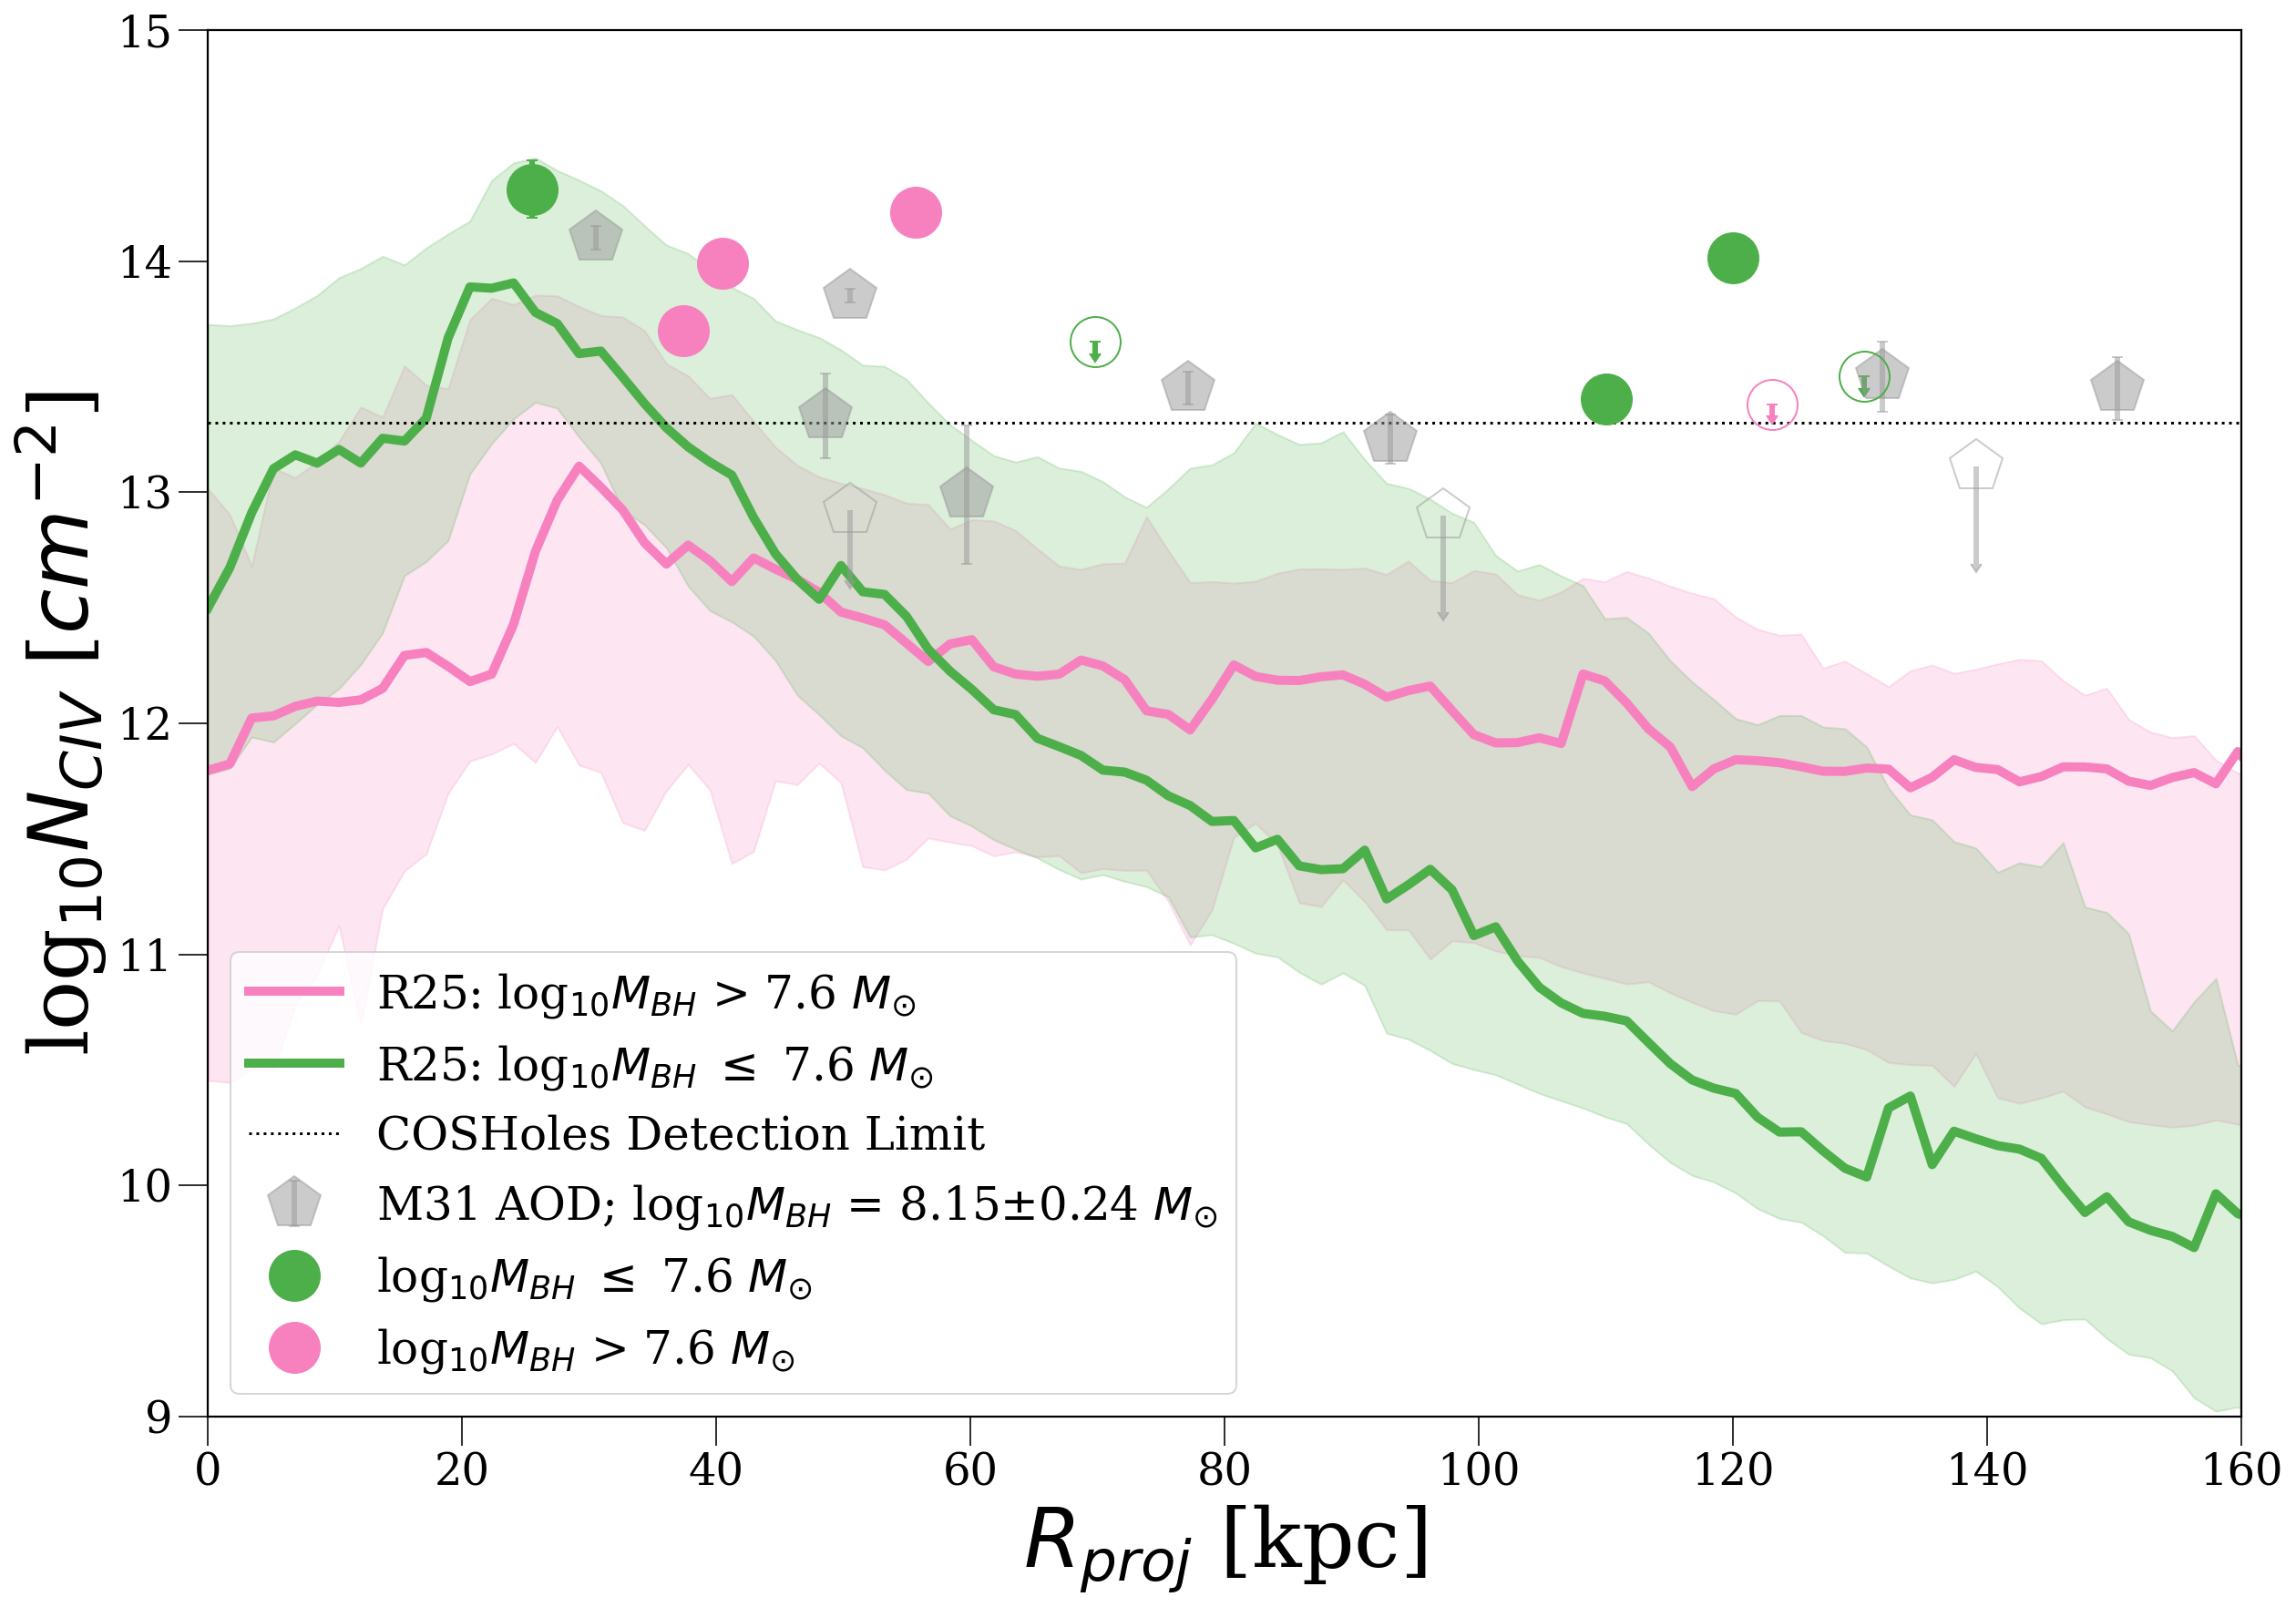

In [369]:
#Plotting NCIV vs Rproj 

#creating masks to separate into high and low 
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)
    
fig, ax = plt.subplots()

########################################################

#R25 Simulational Data

plt.fill_between(R25_df_r['R25_R'], R25_df_r['R25_HMbh_16'], R25_df_r['R25_HMbh_84'], alpha = 0.2, color = CB_color_cycle[3])
plt.plot(R25_df_r['R25_R'],R25_df_r['R25_HMbh_civ'], c = CB_color_cycle[3], linewidth = 5, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$')
plt.fill_between(R25_df_r['R25_R'], R25_df_r['R25_LMbh_16'], R25_df_r['R25_LMbh_84'], alpha = 0.2, color = CB_color_cycle[2])
plt.plot(R25_df_r['R25_R'],R25_df_r['R25_LMbh_civ'], c = CB_color_cycle[2], linewidth = 5, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$')
   
########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 , used lightgrey before 

##### M31 Detections (Sums) 
plt.errorbar (amiga_2_det_sum['Rad'], amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha =0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_2_up_sum['Rad'], amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.5, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=3, fontsize=25)
ax.set_xlabel(r"$R_{proj}$ [kpc]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(9, 15)
ax.set_xlim(0, 160)
#plt.savefig('Figures/nciv_r25_vs_r.png')
plt.show()

<>:11: DeprecationWarning: invalid escape sequence \o
<>:14: DeprecationWarning: invalid escape sequence \l
<>:23: DeprecationWarning: invalid escape sequence \p
<>:11: DeprecationWarning: invalid escape sequence \o
<>:14: DeprecationWarning: invalid escape sequence \l
<>:23: DeprecationWarning: invalid escape sequence \p
<>:11: DeprecationWarning: invalid escape sequence \o
<>:14: DeprecationWarning: invalid escape sequence \l
<>:23: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/1882109193.py:11: DeprecationWarning: invalid escape sequence \o
  label = 'R25: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/1882109193.py:14: DeprecationWarning: invalid escape sequence \l
  label = 'R25: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/1882109193.py:23: DeprecationWarning: invalid escape sequence \p
  alpha =0.5, ma

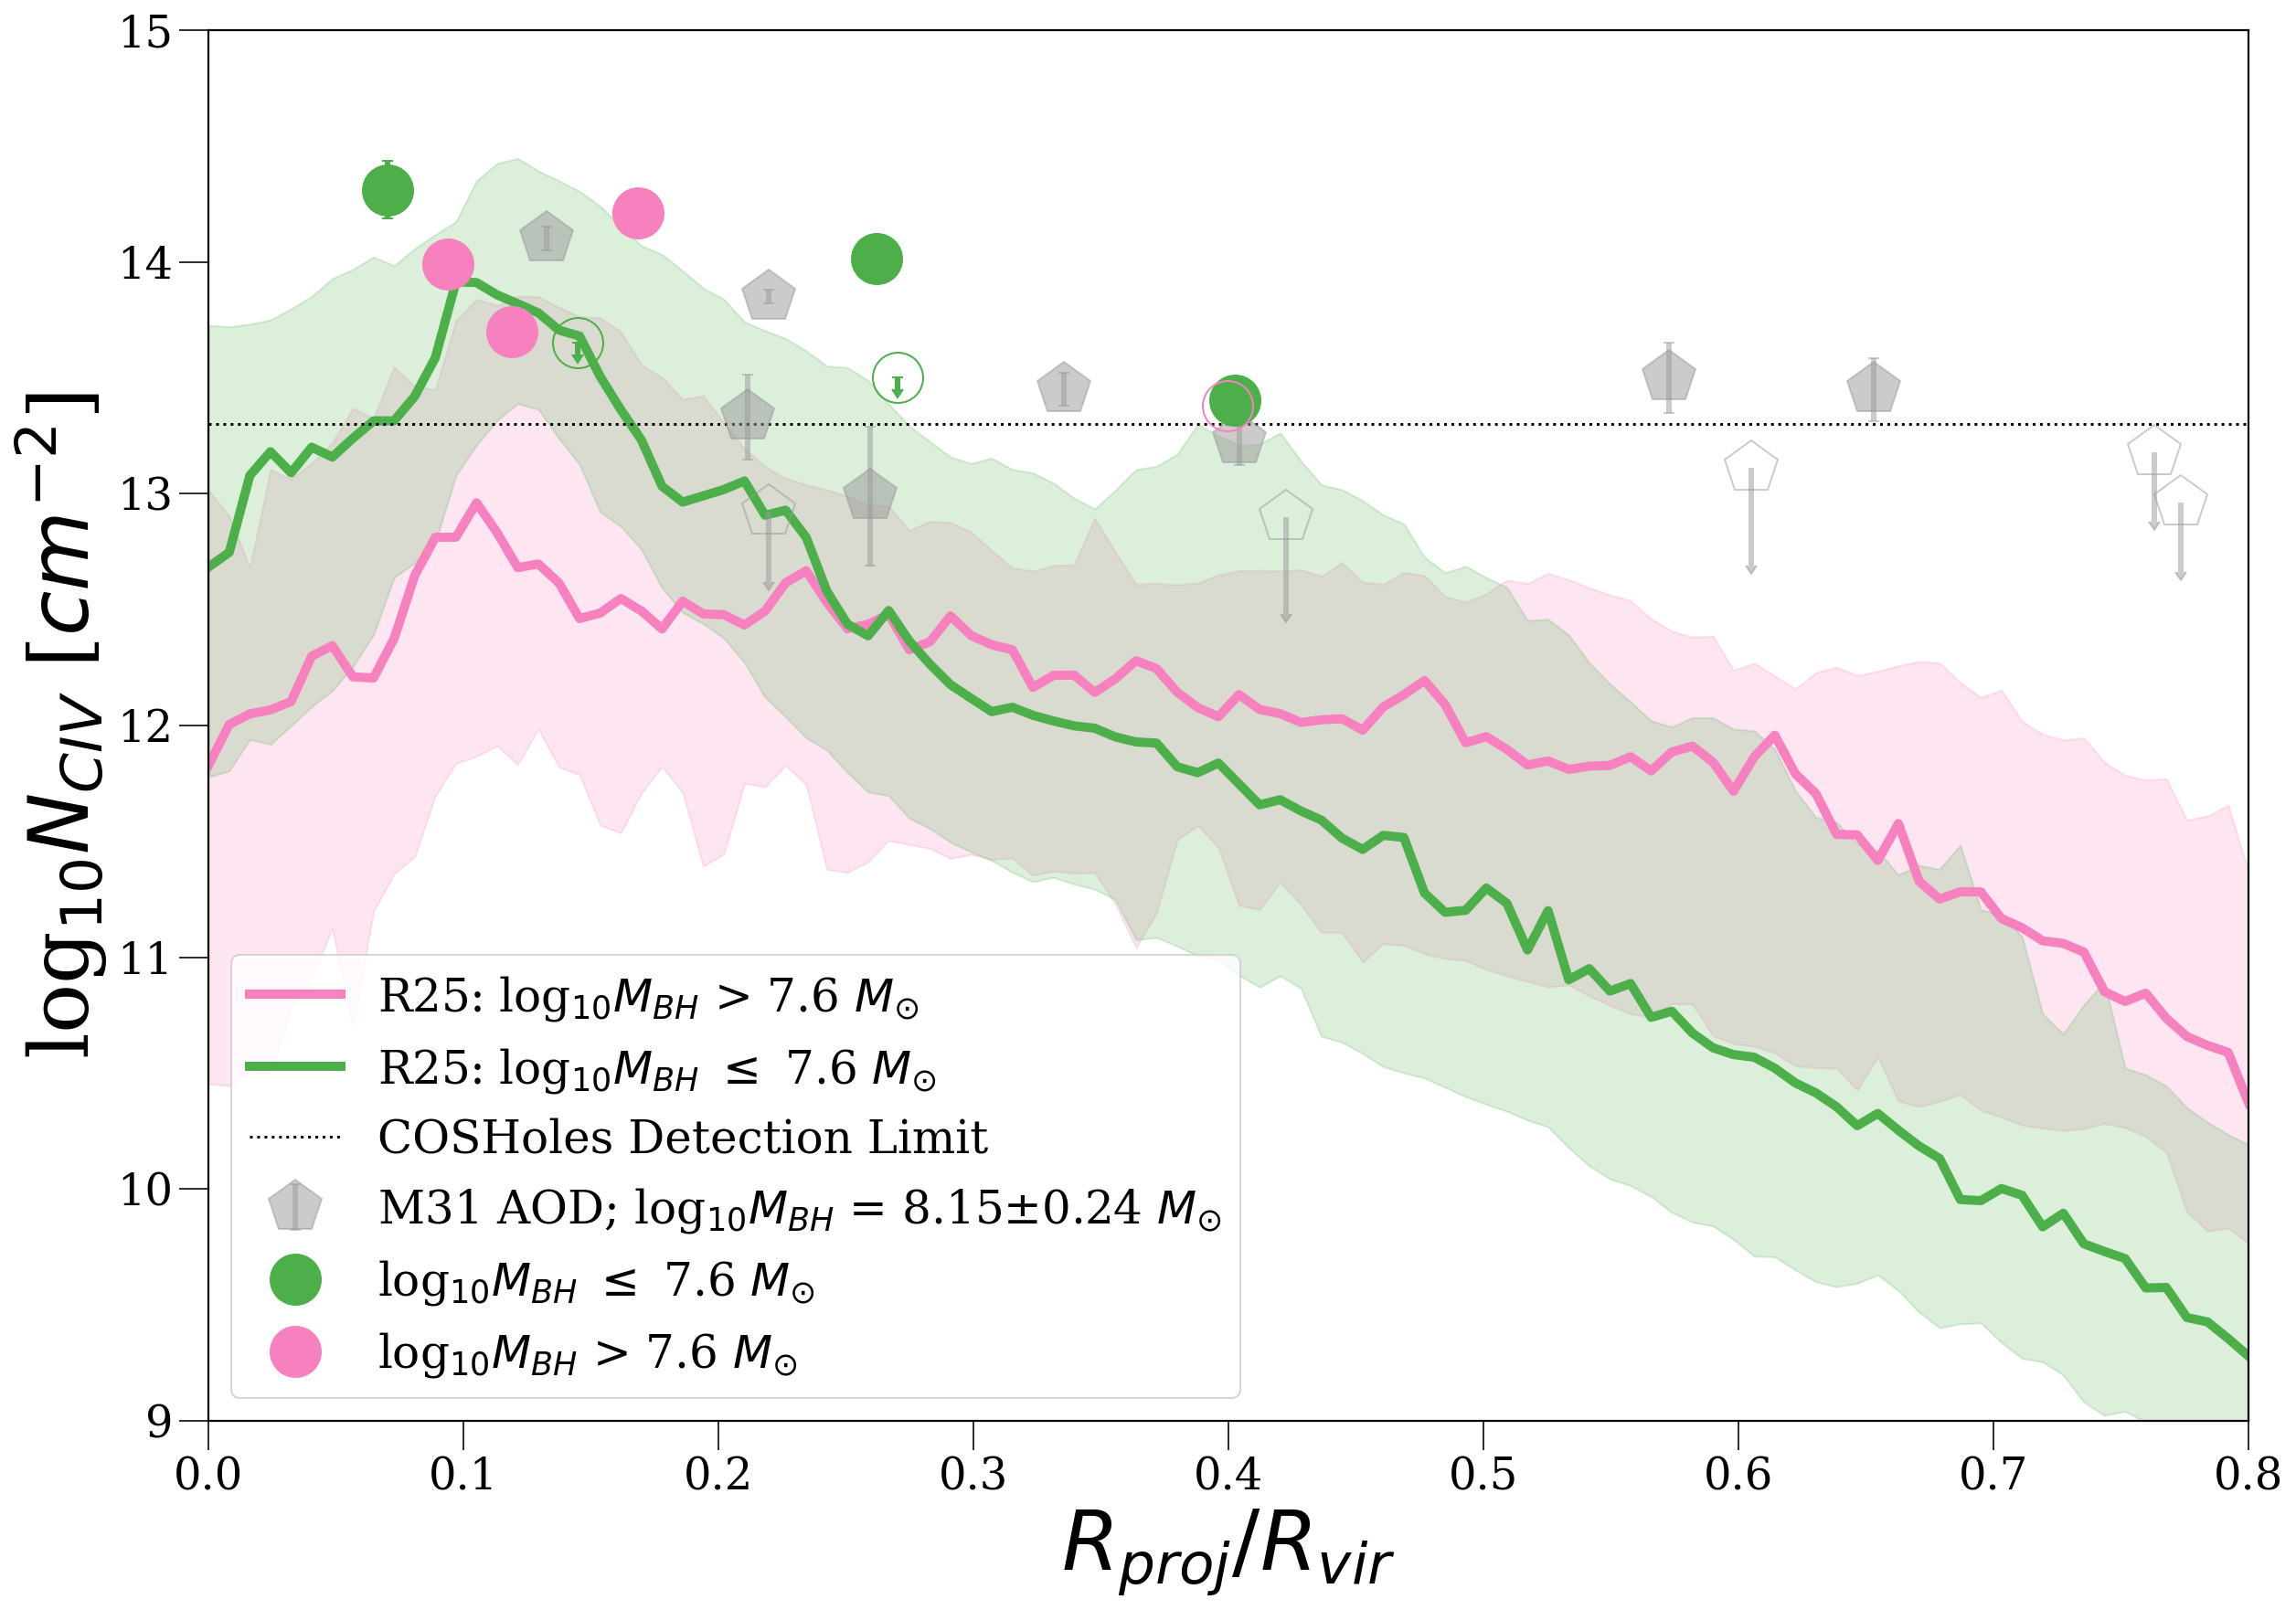

In [370]:
#Plotting NCIV vs Rproj/Rvir

fig, ax = plt.subplots()

########################################################

#R25

plt.fill_between(R25_df_rr['R25_RpRv'], R25_df_rr['R25_HMbh_16'], R25_df_rr['R25_HMbh_84'], alpha = 0.2, color = CB_color_cycle[3])
plt.plot(R25_df_rr['R25_RpRv'],R25_df_rr['R25_HMbh_civ'], c = CB_color_cycle[3], linewidth = 5, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ > 7.6 $M_{\odot}$')
plt.fill_between(R25_df_rr['R25_RpRv'], R25_df_rr['R25_LMbh_16'], R25_df_rr['R25_LMbh_84'], alpha = 0.2, color = CB_color_cycle[2])
plt.plot(R25_df_rr['R25_RpRv'],R25_df_rr['R25_LMbh_civ'], c = CB_color_cycle[2], linewidth = 5, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha =0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.5, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2],CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=3, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(9, 15)
ax.set_xlim(0, 0.8)
#plt.savefig('Figures/nciv_r25_vs_rr.png')
plt.show()

In [37]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the sum values 
r25_sum = {'QSO': ['J1101', 'J1159', 'J1249', 'J1051', 'J1123', 'J0246'],
           'R': [R25_df_r['R25_R'][64], R25_df_r['R25_R'][22], R25_df_r['R25_R'][15], R25_df_r['R25_R'][23], 
                R25_df_r['R25_R'][70], R25_df_r['R25_R'][32]],
           'RR': [R25_df_rr['R25_RpRv'][50], R25_df_rr['R25_RpRv'][14], R25_df_rr['R25_RpRv'][9], 
                        R25_df_rr['R25_RpRv'][12], R25_df_rr['R25_RpRv'][32], R25_df_rr['R25_RpRv'][21]],
           'medianCIV': [R25_df_r['R25_LMbh_civ'][64], R25_df_r['R25_HMbh_civ'][22], R25_df_r['R25_LMbh_civ'][15], 
                        R25_df_r['R25_HMbh_civ'][23], R25_df_r['R25_LMbh_civ'][70], R25_df_r['R25_HMbh_civ'][32]],
           'medianCIVRR': [R25_df_rr['R25_LMbh_civ'][50], R25_df_rr['R25_HMbh_civ'][14], R25_df_rr['R25_LMbh_civ'][9], 
                        R25_df_rr['R25_HMbh_civ'][12], R25_df_rr['R25_LMbh_civ'][32], R25_df_rr['R25_HMbh_civ'][21]]
          }
R25_sum = pd.DataFrame(data=r25_sum)

In [38]:
#New larger df with R25 values included 
R25_sum_ch = pd.merge(sum_ch, R25_sum, on="QSO")
R25_sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,Rproj,Rvir,Rproj/Rvir,line,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim,R,RR,medianCIV,medianCIVRR
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,110.019140,273.43553,0.402359,CIV,1548.204,0.00223,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1,109.898990,0.404040,10.731944,11.747297
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,37.385240,314.35077,0.118928,CIV,1548.204,0.00330,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1,37.777778,0.113131,12.770623,12.830822
2,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,25.520224,363.76792,0.070155,CIV,1548.204,0.00000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1,25.757576,0.072727,13.777617,13.314215
3,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,40.499140,431.64653,0.093825,CIV,1548.204,0.00442,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1,39.494949,0.096970,12.702890,12.812014
4,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,119.976000,458.29968,0.261785,CIV,1548.204,0.00275,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1,120.202020,0.258586,10.397790,12.386433
5,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,55.657239,330.32571,0.168492,CIV,1548.204,0.00422,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1,54.949495,0.169697,12.346426,12.493757


In [39]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the uplim values 

r25_uplim = {'QSO': ['J1220', 'J1222', 'J1235'],
               'R': [R25_df_r['R25_R'][40], R25_df_r['R25_R'][76], R25_df_r['R25_R'][72]],
               'RR': [R25_df_rr['R25_RpRv'][18], R25_df_rr['R25_RpRv'][34], R25_df_rr['R25_RpRv'][49]],
               'medianCIV': [R25_df_r['R25_LMbh_civ'][40], R25_df_r['R25_LMbh_civ'][76], R25_df_r['R25_HMbh_civ'][72]],
               'medianCIVRR': [R25_df_rr['R25_LMbh_civ'][18], R25_df_rr['R25_LMbh_civ'][34], R25_df_rr['R25_HMbh_civ'][49]]
            }
R25_up = pd.DataFrame(data=r25_uplim)

In [40]:
#New larger df with R25 values included 
R25_up_ch = pd.merge(up_ch, R25_up, on="QSO")
R25_up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,Rproj,Rvir,Rproj/Rvir,line,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim,R,RR,medianCIV,medianCIVRR
0,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,69.778997,482.42196,0.144643,CIV,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0,68.686869,0.145455,11.860433,13.679320
1,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,130.305660,482.42196,0.270107,CIV,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0,130.505051,0.274747,10.036282,12.363868
2,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,123.078500,308.12739,0.399440,CIV,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0,123.636364,0.395960,11.829087,12.037444


#### SUMMED VALUES (DET)

In [102]:
#For the actual stats part 
#Need these things in arrays to make it easier to run through the function 
R25_sum_medCIV = np.array(R25_sum_ch['medianCIV'])
R25_sum_medCIVRR = np.array(R25_sum_ch['medianCIVRR'])
sum_civ = np.array(E_sum_ch['N'])

In [103]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (R25_sum_ch["MBH"] <= 7.6), (R25_sum_ch["MBH"] > 7.6)


#For the Rproj plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(R25_sum_medCIV, sum_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj Calculations in {label}: {np.around((std*100)[mask], 2)}')

Sigma values for Rproj Calculations in Low MBH Sample: [267.11  53.37 361.42]
Sigma values for Rproj Calculations in High MBH Sample: [ 92.64 128.71 186.46]


In [104]:
#For the Rproj/Rvir plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(R25_sum_medCIVRR, sum_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj/Rvir Calculations in {label}: {np.round((std*100)[mask],2)}')

Sigma values for Rproj/Rvir Calculations in Low MBH Sample: [165.57  99.71 162.56]
Sigma values for Rproj/Rvir Calculations in High MBH Sample: [ 86.62 117.8  171.72]


#### UPPER LIMITS VALUES (NON-DET)

In [44]:
#Need these things in arrays to make it easier to run through the function 
R25_up_medCIV = np.array(R25_up_ch['medianCIV'])
R25_up_medCIVRR = np.array(R25_up_ch['medianCIVRR'])
up_civ = np.array(R25_up_ch['N'])

In [105]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (R25_up_ch["MBH"] <= 7.6), (R25_up_ch["MBH"] > 7.6)


#For the Rproj plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(R25_up_medCIV, up_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj Calculations in {label}: {np.round((std*100)[mask],2)}')

Sigma values for Rproj Calculations in Low MBH Sample: [178.96 346.37]
Sigma values for Rproj Calculations in High MBH Sample: [155.09]


In [106]:
#For the Rproj/Rvir plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(R25_up_medCIVRR, up_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj/Rvir Calculations in {label}: {np.round((std*100)[mask], 2)}')

Sigma values for Rproj/Rvir Calculations in Low MBH Sample: [  2.93 113.61]
Sigma values for Rproj/Rvir Calculations in High MBH Sample: [134.26]


## Prep for Discussion Simulation Plots (Averages) - Publication Plots in CIV+Lit_Analysis.ipynb

### R25

In [342]:
#Nicole Data (R25 - Rproj/Rvir)
R25_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/New_Data_April20/COSholes_ChaNGa_allMbh_logN_CIV.txt', 
                       sep=" ", header=None, names =['R25_civ'])

#Percentiles 
R25_all_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/New_Data_April20/COSholes_ChaNGa_allMbh_logN_CIV_16percentile.txt', 
                       sep=" ", header=None, names =['R25_all_16'])
R25_all_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/New_Data_April20/COSholes_ChaNGa_allMbh_logN_CIV_84percentile.txt', 
                       sep=" ", header=None, names =['R25_all_84'])



R25_all = pd.concat([R25_civ, R25_all_16, R25_all_84, R25_RpRv], axis=1, join='inner')
#R25_all

<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/4003782196.py:13: DeprecationWarning: invalid escape sequence \l
  c = 'mediumslateblue', linewidth = 5, ls = '--', label = 'R25: 6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/4003782196.py:22: DeprecationWarning: invalid escape sequence \p
  alpha =0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none')


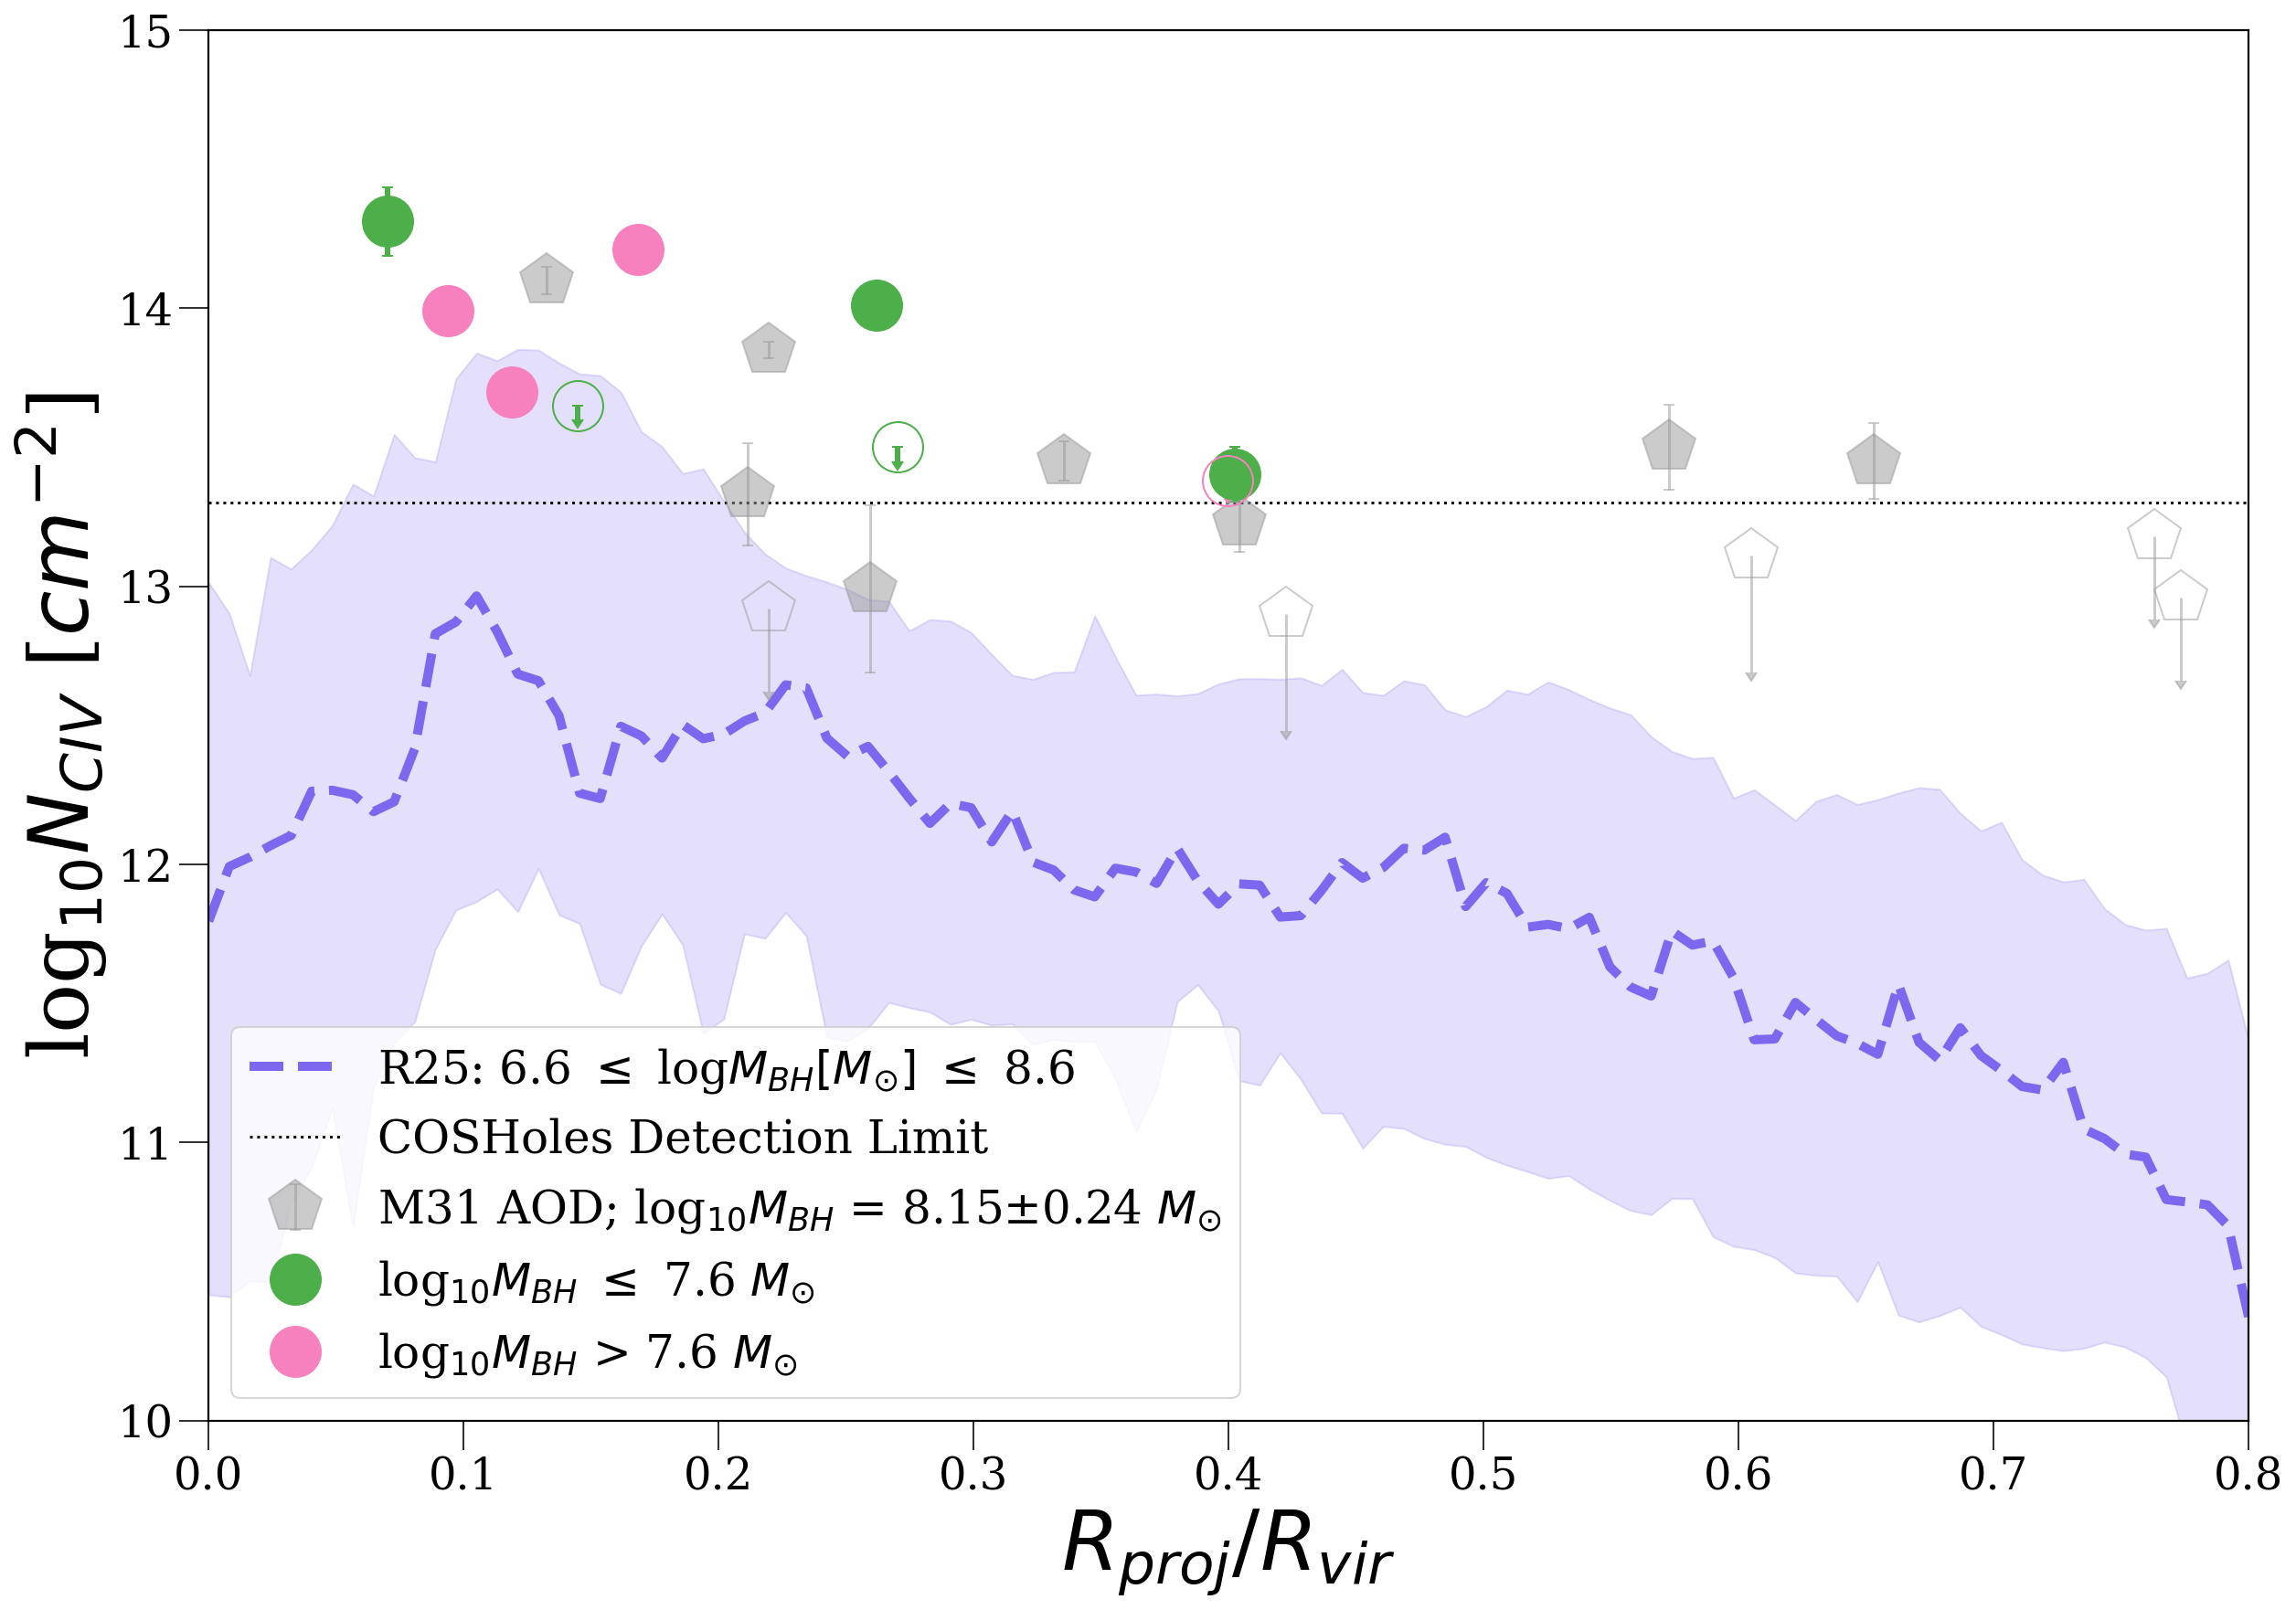

In [365]:
#Plotting NCIV vs Rproj/Rvir

#creating masks to separate into high and low 
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)

fig, ax = plt.subplots()

########################################################

#R25
plt.fill_between(R25_all['R25_RpRv'], R25_all['R25_all_16'], R25_all['R25_all_84'], alpha = 0.2, color = 'mediumslateblue')
plt.plot(R25_all['R25_RpRv'], R25_all['R25_civ'], 
         c = 'mediumslateblue', linewidth = 5, ls = '--', label = 'R25: 6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha =0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none')

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha=0.5, marker="p",mfc='none',markersize=30, ls='none')

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=3, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(10, 15)
ax.set_xlim(0, 0.8)
plt.show()

#### Sigma Calculations

In [357]:
R25_rr_sum = R25_all['R25_RpRv']
R25_rr_med_sum =  R25_all['R25_civ']

#R25_rr_sum

In [348]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the sum values 
r25_avg_sum = {'QSO': ['J1101', 'J1159', 'J1249', 'J1051', 'J1123', 'J0246'],
           'RR': [R25_rr_sum[50], R25_rr_sum[14], R25_rr_sum[9], R25_rr_sum[12], R25_rr_sum[33], R25_rr_sum[21]],
        
           'medianCIVRR': [R25_rr_med_sum[50], R25_rr_med_sum[14], R25_rr_med_sum[9],R25_rr_med_sum[12], R25_rr_med_sum[33], R25_rr_med_sum[21]]}

R25_avg_sum = pd.DataFrame(data=r25_avg_sum)

In [349]:
#New larger df with R25 values included 
R25_avg_sum_ch = pd.merge(sum_ch, R25_avg_sum, on="QSO")
R25_avg_sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,Rproj,Rvir,Rproj/Rvir,line,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim,RR,medianCIVRR
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,110.019140,273.43553,0.402359,CIV,1548.204,0.00223,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1,0.404040,11.930210
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,37.385240,314.35077,0.118928,CIV,1548.204,0.00330,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1,0.113131,12.836797
2,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,25.520224,363.76792,0.070155,CIV,1548.204,0.00000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1,0.072727,12.225392
3,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,40.499140,431.64653,0.093825,CIV,1548.204,0.00442,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1,0.096970,12.871774
4,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,119.976000,458.29968,0.261785,CIV,1548.204,0.00275,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1,0.266667,12.333612
5,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,55.657239,330.32571,0.168492,CIV,1548.204,0.00422,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1,0.169697,12.461878


In [358]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the uplim values 

r25_avg_uplim = {'QSO': ['J1220', 'J1222', 'J1235'],
               'RR': [R25_rr_sum[18], R25_rr_sum[34], R25_rr_sum[49]],
               #'R': [],
               'medianCIVRR': [R25_rr_med_sum[18], R25_rr_med_sum[34], R25_rr_med_sum[49]]
               #'medianCIVR': []
            }
R25_avg_up = pd.DataFrame(data=r25_avg_uplim)

In [359]:
#New larger df with R25 values included 
R25_avg_up_ch = pd.merge(up_ch, R25_avg_up, on="QSO")
R25_avg_up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,Rproj,Rvir,Rproj/Rvir,line,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim,RR,medianCIVRR
0,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,69.778997,482.42196,0.144643,CIV,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0,0.145455,12.256499
1,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,130.305660,482.42196,0.270107,CIV,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0,0.274747,12.238311
2,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,123.078500,308.12739,0.399440,CIV,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0,0.395960,11.857292


##### SUMMED VALUES (DET)

In [352]:
#Actual Stats part 

#Need these things in arrays to make it easier to run through the function 

#E_avg_sum_medCIV = np.array(E_avg_sum_ch['medianCIV'])
R25_avg_sum_medCIVRR = np.array(R25_avg_sum_ch['medianCIVRR'])
sum_civ = np.array(R25_avg_sum_ch['N'])

In [353]:
#Finding the sigma values and using the masks to separate values into low and high sample

#For the Rproj/Rvir plot 

var = variance(R25_avg_sum_medCIVRR, sum_civ)
std = np.sqrt(var)
    
print('Sigma values for Rproj/Rvir Calculations:', np.round((std*100),2))

Sigma values for Rproj/Rvir Calculations: [147.28  86.02 208.59 111.82 167.84 174.91]


##### UPPER LIMS (NON-DET)

In [360]:
#Actual Stats part 

#Need these things in arrays to make it easier to run through the function 

#E_avg_sum_medCIV = np.array(E_avg_sum_ch['medianCIV'])
R25_avg_up_medCIVRR = np.array(R25_avg_up_ch['medianCIVRR'])
sum_civ = np.array(R25_avg_up_ch['N'])

In [361]:
#For the Rproj/Rvir plot 

var = variance(R25_avg_up_medCIVRR, sum_civ)
std = np.sqrt(var)
    
print('Sigma values for Rproj/Rvir Calculations:', np.round((std*100), 2))

Sigma values for Rproj/Rvir Calculations: [139.35 126.17 152.27]


### EAGLE 

In [268]:
df_rr_eagle = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/Fig8_singlebin/profile_coll_EAGLE.halo.list.CIV_median.MBH66_86_1bins.MS100_110.6.6_8.6.csv", sep=",")
df_r_eagle = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/Fig8_singlebin/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH66_86_1bins.MS100_110.6.6_8.6.csv", sep=",")

In [271]:
df_rr_eagle

,#R/R200,median,16percentile,84percentile,lowparam,highparam,numofgal
0,0.00000,14.21,13.72,14.54,6.6,8.6,1249
1,0.07143,14.05,13.53,14.37,6.6,8.6,1249
2,0.14290,13.90,13.38,14.22,6.6,8.6,1249
3,0.21430,13.76,13.24,14.09,6.6,8.6,1249
4,0.28570,13.65,13.07,13.99,6.6,8.6,1249
5,0.35710,13.56,12.91,13.93,6.6,8.6,1249
6,0.42860,13.50,12.82,13.87,6.6,8.6,1249
7,0.50000,13.43,12.70,13.84,6.6,8.6,1249
8,0.57140,13.34,12.59,13.74,6.6,8.6,1249
9,0.64290,13.21,12.41,13.61,6.6,8.6,1249


<>:15: DeprecationWarning: invalid escape sequence \l
<>:24: DeprecationWarning: invalid escape sequence \p
<>:15: DeprecationWarning: invalid escape sequence \l
<>:24: DeprecationWarning: invalid escape sequence \p
<>:15: DeprecationWarning: invalid escape sequence \l
<>:24: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/471804094.py:15: DeprecationWarning: invalid escape sequence \l
  color = 'mediumpurple', lw = 5, label = 'EAGLE:  6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_3781/471804094.py:24: DeprecationWarning: invalid escape sequence \p
  alpha=0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24', ls='none', elinewidth=3)


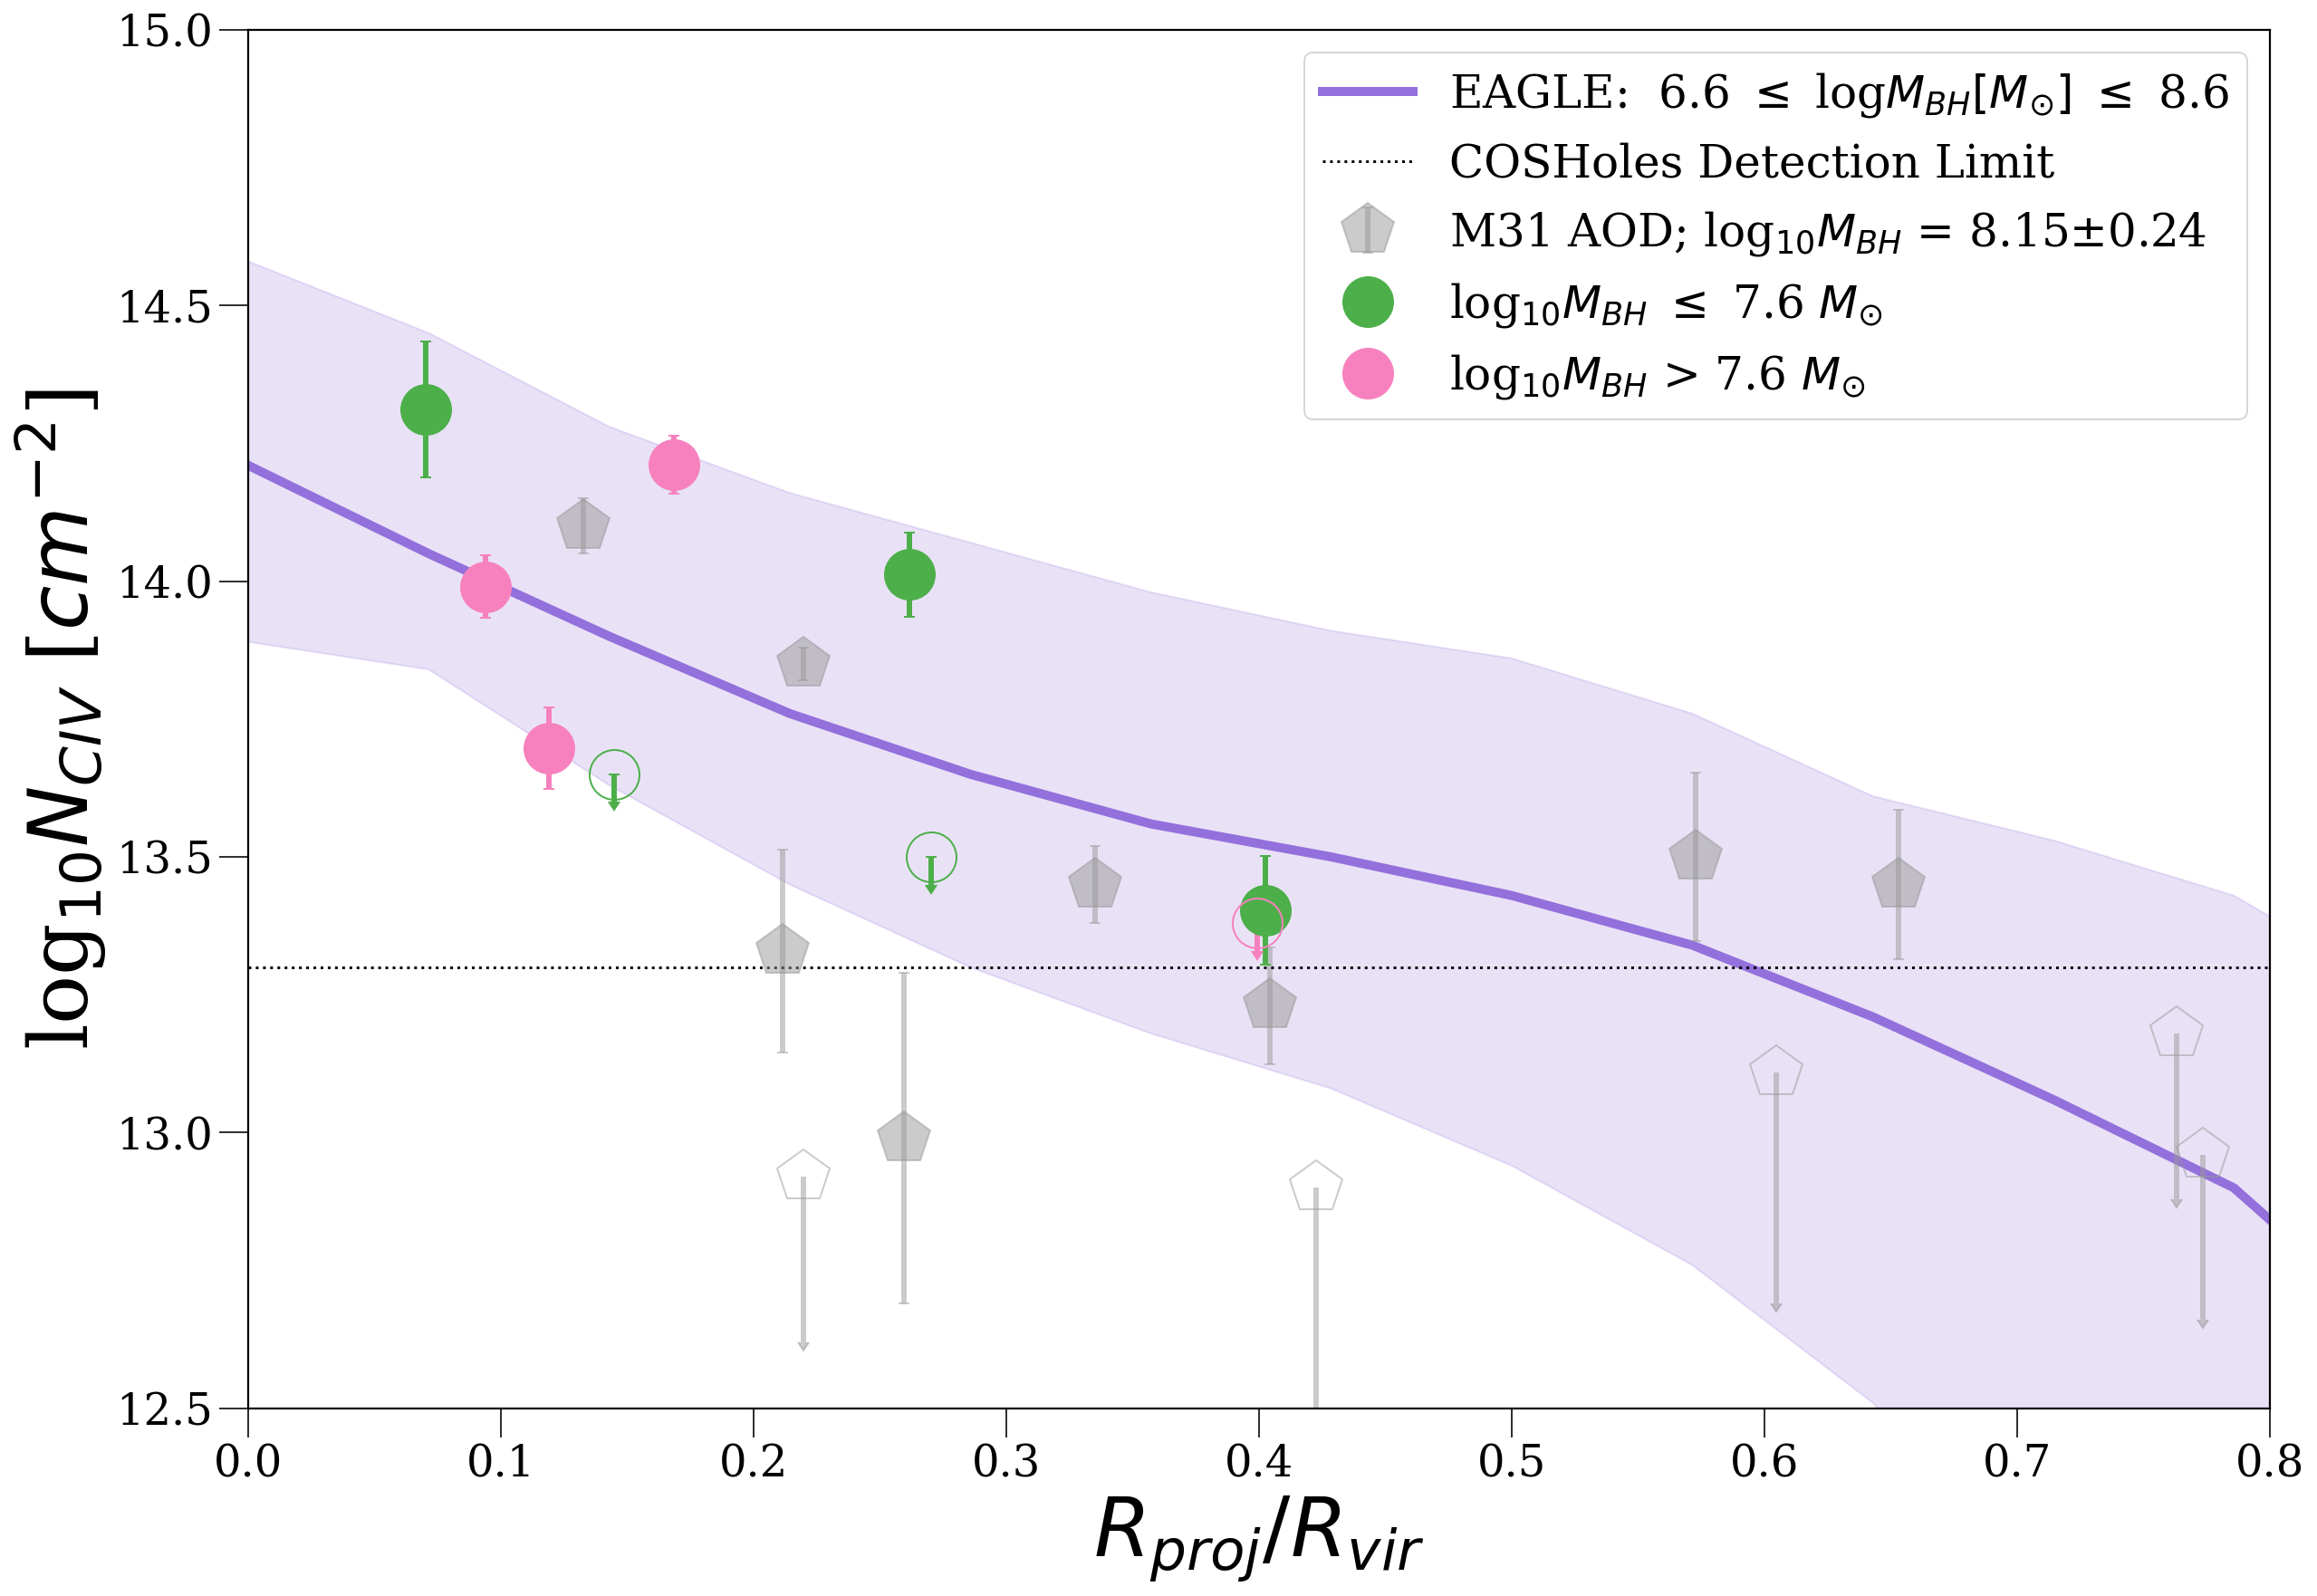

In [368]:
#Plotting NCIV vs Rproj/Rvir

#creating masks to separate into high and low 
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)

fig, ax = plt.subplots()

########################################################

#EAGLE

plt.fill_between(df_rr_eagle['#R/R200'], df_rr_new_low['16percentile'], df_rr_new_low['84percentile'], alpha = 0.2, 
                 color = 'mediumpurple')
plt.plot(df_rr_eagle['#R/R200'], df_rr_eagle['median'], 
         color = 'mediumpurple', lw = 5, label = 'EAGLE:  6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha=0.5, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha=0.5, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], [CB_color_cycle[2], CB_color_cycle[3]], 
                               [r"log$_{10}M_{BH}$ $\leq$ 7.6 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 7.6 $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

ax.legend(loc=1, fontsize=25)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(12.5, 15)
ax.set_xlim(0, 0.8)
plt.show()

#### Sigma Calculations

In [272]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the sum values 
eagle_avg_sum = {'QSO': ['J1101', 'J1159', 'J1249', 'J1051', 'J1123', 'J0246'],
           'RR': [df_rr_eagle['#R/R200'][6], df_rr_eagle['#R/R200'][2], df_rr_eagle['#R/R200'][1], df_rr_eagle['#R/R200'][1], 
                  df_rr_eagle['#R/R200'][4], df_rr_eagle['#R/R200'][2]],
           #'R': [],
           'medianCIVRR': [df_rr_eagle['median'][6], df_rr_eagle['median'][2], df_rr_eagle['median'][1], df_rr_eagle['median'][1], 
                           df_rr_eagle['median'][4], df_rr_eagle['median'][2]]
           #'medianCIV': []
          }
E_avg_sum = pd.DataFrame(data=eagle_avg_sum)

In [273]:
#New larger df with R25 values included 
E_avg_sum_ch = pd.merge(sum_ch, E_avg_sum, on="QSO")
E_avg_sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,Rproj,Rvir,Rproj/Rvir,line,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim,RR,medianCIVRR
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,110.019140,273.43553,0.402359,CIV,1548.204,0.00223,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1,0.42860,13.50
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,37.385240,314.35077,0.118928,CIV,1548.204,0.00330,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1,0.14290,13.90
2,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,25.520224,363.76792,0.070155,CIV,1548.204,0.00000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1,0.07143,14.05
3,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,40.499140,431.64653,0.093825,CIV,1548.204,0.00442,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1,0.07143,14.05
4,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,119.976000,458.29968,0.261785,CIV,1548.204,0.00275,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1,0.28570,13.65
5,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,55.657239,330.32571,0.168492,CIV,1548.204,0.00422,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1,0.14290,13.90


In [274]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the uplim values 

E_avg_uplim = {'QSO': ['J1220', 'J1222', 'J1235'],
               'RR': [df_rr_eagle['#R/R200'][2], df_rr_eagle['#R/R200'][4], df_rr_eagle['#R/R200'][5]],
               #'R': [],
               'medianCIVRR': [df_rr_eagle['median'][2], df_rr_eagle['median'][4], df_rr_eagle['median'][5]]
               #'medianCIVR': []
            }
E_avg_up = pd.DataFrame(data=E_avg_uplim)

In [275]:
#New larger df with R25 values included 
E_avg_up_ch = pd.merge(up_ch, E_avg_up, on="QSO")
E_avg_up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,Rproj,Rvir,Rproj/Rvir,line,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim,RR,medianCIVRR
0,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,69.778997,482.42196,0.144643,CIV,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0,0.1429,13.90
1,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,130.305660,482.42196,0.270107,CIV,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0,0.2857,13.65
2,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,123.078500,308.12739,0.399440,CIV,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0,0.3571,13.56


##### SUMMED VALUES (DET)

In [276]:
#Actual Stats part 

#Need these things in arrays to make it easier to run through the function 

#E_avg_sum_medCIV = np.array(E_avg_sum_ch['medianCIV'])
E_avg_sum_medCIVRR = np.array(E_avg_sum_ch['medianCIVRR'])
sum_civ = np.array(E_avg_sum_ch['N'])

In [277]:
#Finding the sigma values and using the masks to separate values into low and high sample

#For the Rproj/Rvir plot 

var = variance(E_avg_sum_medCIVRR, sum_civ)
std = np.sqrt(var)
    
print('Sigma values for Rproj/Rvir Calculations:', np.round((std*100),2))

Sigma values for Rproj/Rvir Calculations: [ 9.7  20.3  26.13  6.   36.2  31.1 ]


##### UPPER LIMITS (NON-DET)

In [278]:
#Actual Stats part 

#Need these things in arrays to make it easier to run through the function 

#E_avg_sum_medCIV = np.array(E_avg_sum_ch['medianCIV'])
E_avg_up_medCIVRR = np.array(E_avg_up_ch['medianCIVRR'])
sum_civ = np.array(E_avg_up_ch['N'])

In [279]:
#For the Rproj/Rvir plot 

var = variance(E_avg_up_medCIVRR, sum_civ)
std = np.sqrt(var)
    
print('Sigma values for Rproj/Rvir Calculations:', np.round((std*100), 2))

Sigma values for Rproj/Rvir Calculations: [25. 15. 18.]


## RECAP OF STATISTICS: 

### EAGLE: 
- NORMAL
    - Rproj: 
        - LOW: all values within 1 sigma (11.7, 17.13, 65.2, 8, 9)
        - HIGH: all values within 1 sigma (9.3, 26.0, 55.1, 6)
    - Rproj/Rvir: 
        - LOW: all values within 1 sigma (17.7, 13.13, 26.2, 36, 25)
        - HIGH: all values within 1 sigma (48.3, 19.,  20.1, 1)
- Single Bin: 
    - Rproj/Rvir: all values are within 1 sigma  
        - (9.7, 20.3, 26.13, 6, 36.2, 31.1, 25, 15, 18) 
    
### R25: 
- NORMAL: 
    - Rproj:
        - LOW: most values are above 3 sigma, but one is 1 sigma (267.11, 53.37, 361.42, 178.96, 346.37)
        - HIGH: one 2 sigma and rest are over 3 sigma (92.64, 128.71, 186.46, 155.09)
    - Rproj/Rvir: 
        - LOW: one 1 sigma, one 2 sigma, and rest are over 3 sigma (165.57,  99.71, 162.56, 2.93, 113.61)
        - HIGH: one 2 sigma and rest are over 3 sigma (86.62, 117.8,  171.72, 134.26)
- AVG: 
    - Rproj/Rvir: one 1 sigmas and rest are over 3 sigma  
        - (147.28,  86.02, 208.59, 111.82, 167.84, 174.91, 139.35, 126.17, 152.27)
        - (146.28,  35.3,  146.69,  62.72, 152.49, 134.84, 58., 101.29, 144.25) #these are the old values and not sure why we lost 2 of the 1 sigma values 😭


## MINIMUM MASS OF CGM CARBON

Using Bordoloi et al 2014 (equation 5)

In [378]:
from astropy import constants as const

N_det = np.array(sum_ch['N']) #cm^12
N_up = np.array(up_ch['N']) #cm^12
N_all = np.concatenate((N_det,N_up)) #cm^12

N_mean_all = np.mean(N_all) #* (u.cm)**-2
N_mean_det = np.mean(N_det) #* (u.cm)**-2

R = 140 #* u.kpc 
fCIV = 0.3 #* (u.cm**2/u.kpc**2)

In [379]:
N_mean_det

13.937387218333335

In [375]:
m = 1.2e6 * (10**N_mean_sum / 10**14) * .66 * (R/110)**2 * u.M_sun

In [376]:
print('Minimum Carbon Mass Estimate:' + "{:e}".format(m))

Minimum Carbon Mass Estimate:1.110665e+06 solMass
